In [ ]:
import torch
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import resample
from sklearn.cluster import KMeans
from scipy.linalg import sqrtm
from kneed import KneeLocator

import random
import sys
import warnings
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import Counter
import os
import seaborn as sb

from metrics import *
from Misc import *
from Classifier import NeuralNetwork, LogisticRegression, SVM, RandomForest, DecisionTree
from utils import *
from DatasetExt import *
from influence import *
from Algorithms import *

#np.random.seed(42)
torch.manual_seed(1)

## Define Dataset's name

In [161]:
dataset_name='income'
model='LR'
metric='sp'

## Partition

In [162]:
'''state_data_counts = {}
all_states = [state.abbr for state in us.states.STATES]
for state in all_states:
    df= load_acs_data(dataset_name, year='2018', states=[state], horizon='1-Year')
    state_data_counts[state] = df.shape[0]
top_five_states = sorted(state_data_counts, key=state_data_counts.get, reverse=True)[:4]
clustered_data = []
states_name=[]

for state in top_five_states:
    df = load_acs_data(dataset_name, states=[state])
    clustered_data.append((df))'''

"state_data_counts = {}\nall_states = [state.abbr for state in us.states.STATES]\nfor state in all_states:\n    df= load_acs_data(dataset_name, year='2018', states=[state], horizon='1-Year')\n    state_data_counts[state] = df.shape[0]\ntop_five_states = sorted(state_data_counts, key=state_data_counts.get, reverse=True)[:4]\nclustered_data = []\nstates_name=[]\n\nfor state in top_five_states:\n    df = load_acs_data(dataset_name, states=[state])\n    clustered_data.append((df))"

In [163]:
'''for state_name, df in zip(top_five_states, clustered_data):
    print(f"Shape of data for {state_name}: {df.shape}")'''

'for state_name, df in zip(top_five_states, clustered_data):\n    print(f"Shape of data for {state_name}: {df.shape}")'

## Load Dataset

In [164]:
datapool, test_orig_df=load_data(dataset_name)
Target_attribute, Sensitive_attribute, protected_group, privileged_group= get_target_sensitive_attribute(dataset_name)
dataset_orig_df = pd.concat([datapool, test_orig_df], ignore_index=True)

## Example Data

In [165]:
#datapool = datapool.sample(n=600, replace=False, random_state=42)
#Display the sampled data
#print(datapool)

## Define Training and Budget Percentages

In [166]:
train_pct=5
train_size=int(dataset_orig_df.shape[0]*(train_pct/100))

In [167]:
train_smart_df= smart_sample(datapool, train_size, 50, 90, dataset_name)  #keep it balance for the sake of accuracy
datapool = datapool.drop(train_smart_df.index)

In [168]:
print("Original dataset: ", dataset_orig_df.shape)
print("Train set: ", train_smart_df.shape)
print("Test set: ", test_orig_df.shape)
print("Size of Data Pool: ", datapool.shape)

Original dataset:  (195665, 11)
Train set:  (9783, 11)
Test set:  (39133, 11)
Size of Data Pool:  (146749, 11)


In [169]:
#datapool = datapool.sample(n=100000, replace=False, random_state=42)
#print(datapool)

## Stratification

In [170]:
'''
from itertools import product

# Define the order you want: (SEX, Income)
order = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Create the list of partitions (each item is a DataFrame)
clustered_data = [
    datapool[(datapool["SEX"] == s) & (datapool["Income"] == inc)].copy()
    for s, inc in order
]'''

'\nfrom itertools import product\n\n# Define the order you want: (SEX, Income)\norder = [(0, 0), (0, 1), (1, 0), (1, 1)]\n\n# Create the list of partitions (each item is a DataFrame)\nclustered_data = [\n    datapool[(datapool["SEX"] == s) & (datapool["Income"] == inc)].copy()\n    for s, inc in order\n]'

## Synthetic

In [171]:
#datapool_orig=datapool.copy()
#datapool = generate_synthetic_data(datapool_orig, 500000)

## Budget, mini-batch define

In [172]:
budget_pct=20
mini_batch_pct=10
data_acq_size=int(datapool.shape[0]*budget_pct//100)
mini_batch_size=int(data_acq_size*(mini_batch_pct/100))
print('mini batch size:', mini_batch_size)
print('Budget Size:', data_acq_size)

mini batch size: 2934
Budget Size: 29349


In [173]:
print("Original dataset: ", dataset_orig_df.shape)
print("Train set: ", train_smart_df.shape)
print("Test set: ", test_orig_df.shape)
print("Size of Data Pool: ", datapool.shape)

Original dataset:  (195665, 11)
Train set:  (9783, 11)
Test set:  (39133, 11)
Size of Data Pool:  (146749, 11)


## Initial Model Training

In [174]:
X_train = train_smart_df.drop(columns=[Target_attribute])
y_train = train_smart_df[Target_attribute]
X_test = test_orig_df.drop(columns=[Target_attribute])
y_test = test_orig_df[Target_attribute]

In [175]:
X_train.head(5)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
100350,47.0,6.0,16.0,1.0,6200.0,6.0,1.0,55.0,1,1
98395,59.0,1.0,23.0,5.0,4760.0,6.0,11.0,40.0,1,1
129600,29.0,1.0,21.0,5.0,1530.0,247.0,2.0,40.0,1,1
185437,38.0,7.0,22.0,1.0,705.0,120.0,0.0,60.0,1,1
137304,27.0,1.0,21.0,5.0,1006.0,6.0,0.0,50.0,1,1


In [176]:
model_smart=LogisticRegression(input_size=X_train.shape[-1])

In [177]:
X_train, X_test, y_train, y_test, X_train_orig, X_test_orig=prepare_train_data(train_smart_df, test_orig_df, Target_attribute)

In [178]:
num_params = len(convert_grad_to_ndarray(list(model_smart.parameters())))
if isinstance(model_smart, LogisticRegression):
    loss_func = logistic_loss_torch
elif isinstance(model_smart, SVM):
    loss_func = svm_loss_torch
elif isinstance(model_smart, NeuralNetwork):
    loss_func = nn_loss_torch

In [179]:
model_smart.fit(X_train, y_train)
y_pred_test = model_smart.predict_proba(X_test)
y_pred_train = model_smart.predict_proba(X_train)

In [180]:
spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset_name)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset_name)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)


Initial statistical parity:  -0.3400853223631243
Initial TPR parity:  -0.3075335581284594
Initial predictive parity:  -0.05125313408858656
Initial loss:  0.5718978249545676
Initial accuracy:  0.7025272787672808


In [181]:
ini_parity=spd_0
X_train_full, X_test_full, y_train_full, y_test_full, X_train_orig_full, X_test_orig_full=prepare_train_data(dataset_orig_df, test_orig_df, Target_attribute)
model_full=copy.deepcopy(model_smart)
model_full.fit(X_train_full, y_train_full)   
y_pred_test_full=model_full.predict_proba(X_test)
full_parity = computeFairness(y_pred_test_full, X_test_orig, y_test, 0, dataset_name)
ini_acc=computeAccuracy(y_test_full, y_pred_test_full)
print('Initial Parity', ini_parity)
print('Fairness for Entire Data Pool', full_parity)

Initial Parity -0.3400853223631243
Fairness for Entire Data Pool -0.0872715838868744


In [182]:
privileged_positive, privileged_negative, protected_positive, protected_negative, privieleged_data_full, protected_data_full = get_group_count(dataset_orig_df, dataset_name)

In [183]:
privileged_positive_train, privileged_negative_train, protected_positive_train, protected_negative_train, privieleged_data_full_train, protected_data_full_train = get_group_count(train_smart_df, dataset_name)

## Distribution Check

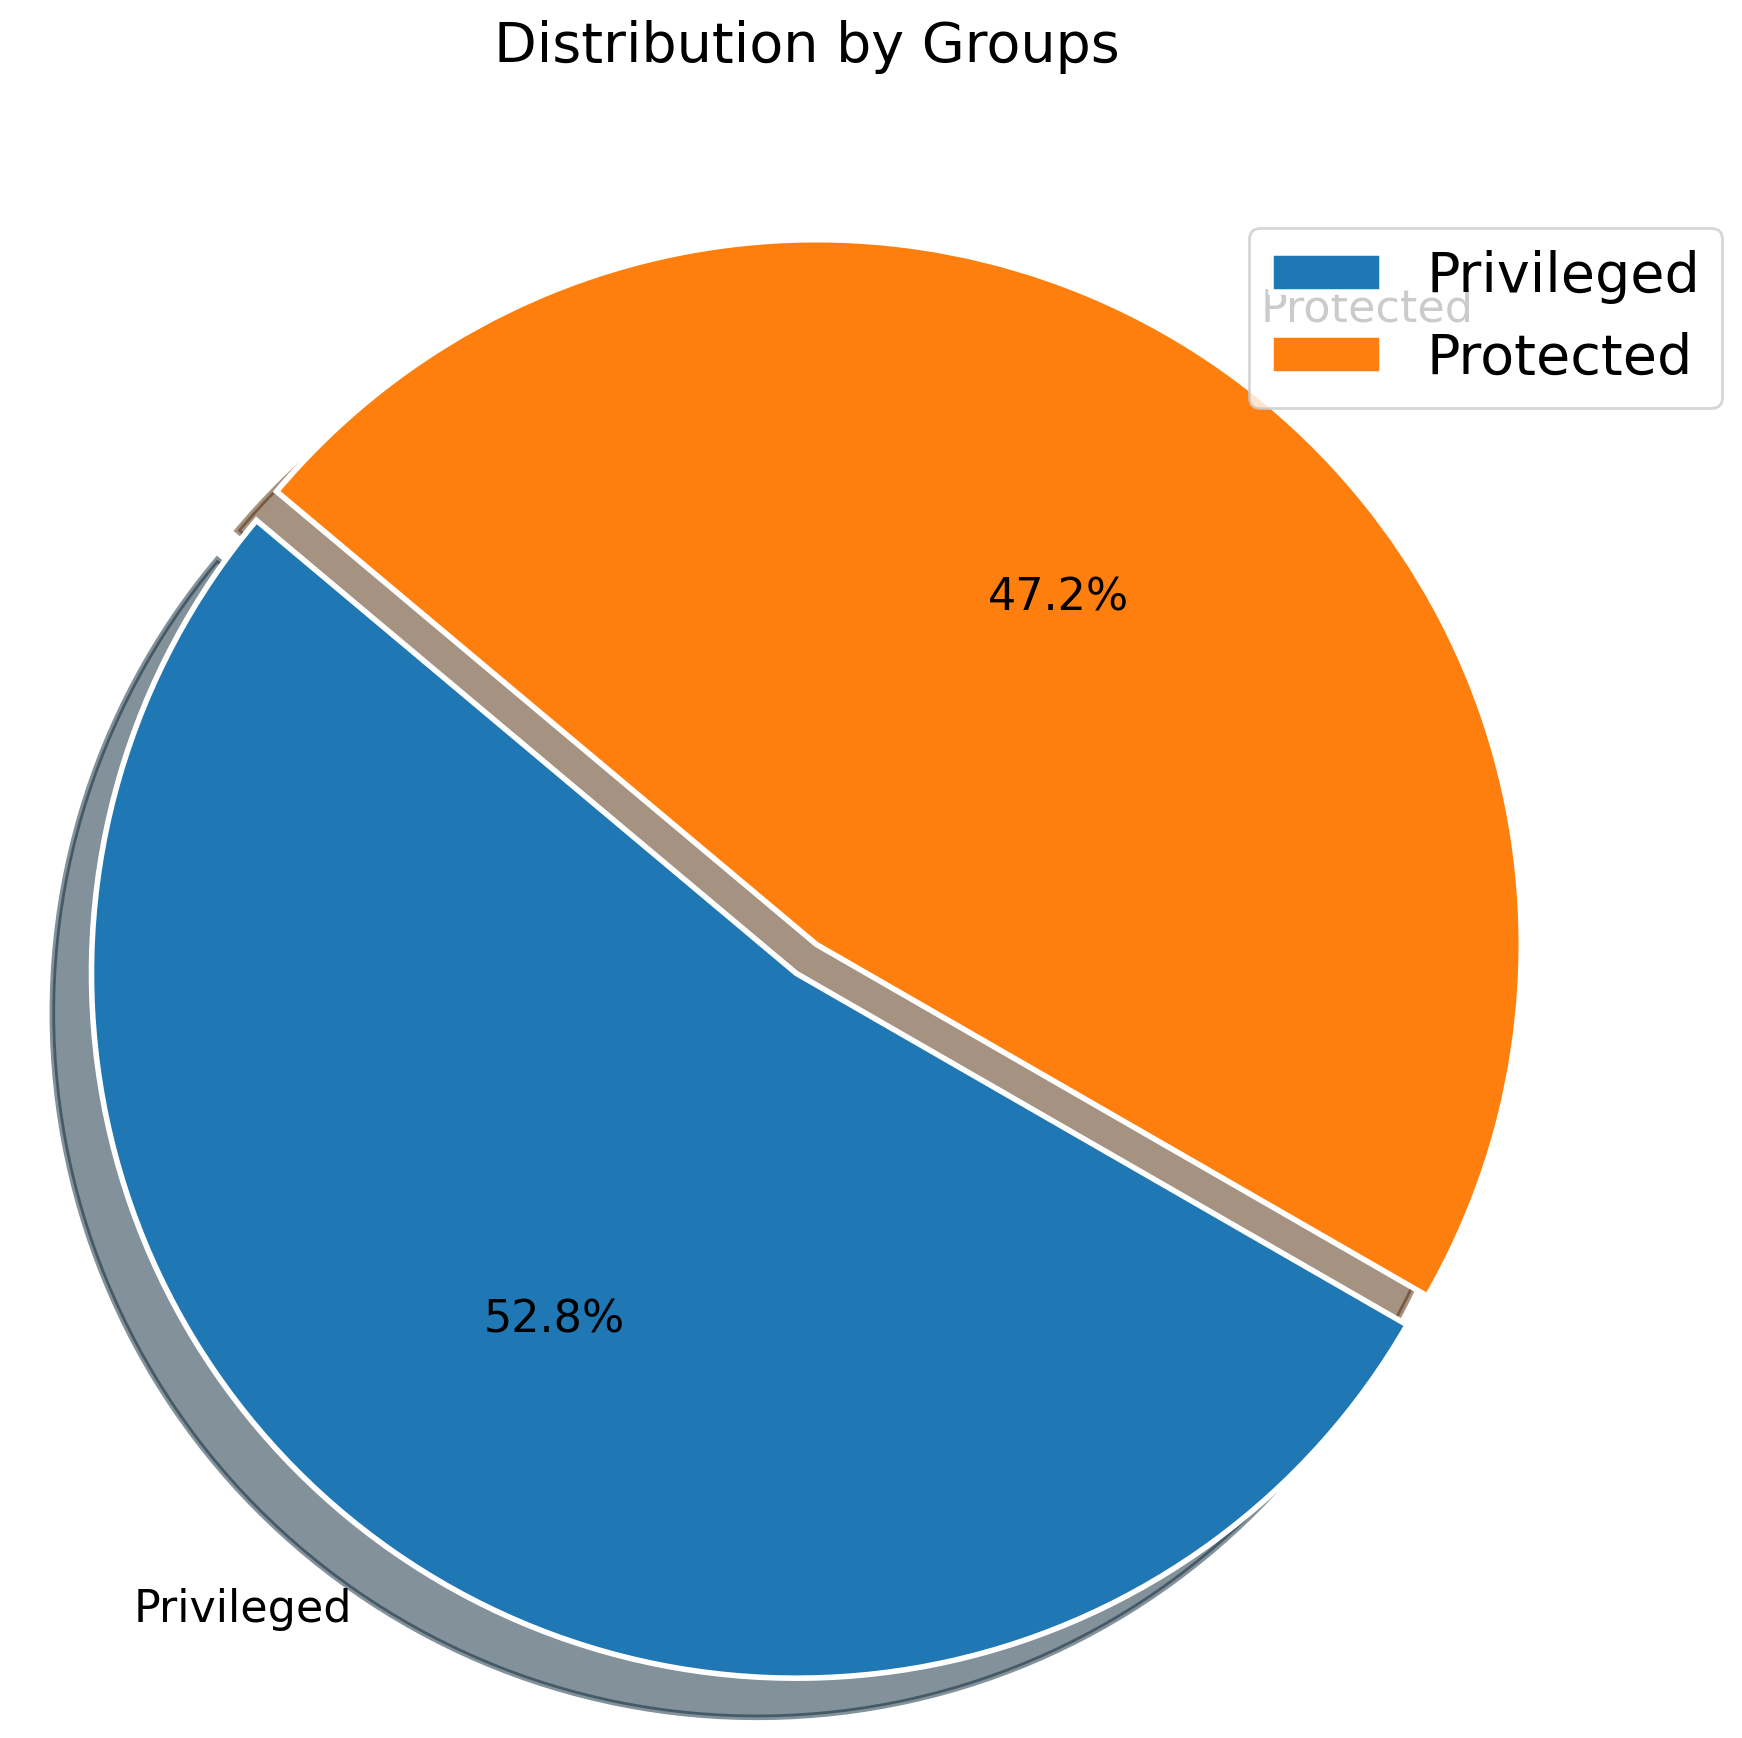

In [184]:
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 18, 'font.family': 'DejaVu Sans', 'figure.dpi': 200})

labels = ['Privileged', 'Protected']
values = [privieleged_data_full.shape[0], protected_data_full.shape[0]]

colors = ['#1f77b4', '#ff7f0e']
explode = (0.05, 0)

plt.figure(figsize=(10, 10))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, 
        explode=explode, colors=colors, shadow=True, 
        textprops={'fontsize': 16}, wedgeprops={'linewidth': 2, 'edgecolor': 'white'})

plt.title('Distribution by Groups', fontsize=20, y=1.08)
plt.legend(labels, loc="upper right", bbox_to_anchor=(1.1, 1))
plt.axis('equal')
plt.tight_layout(pad=3)
plt.show()

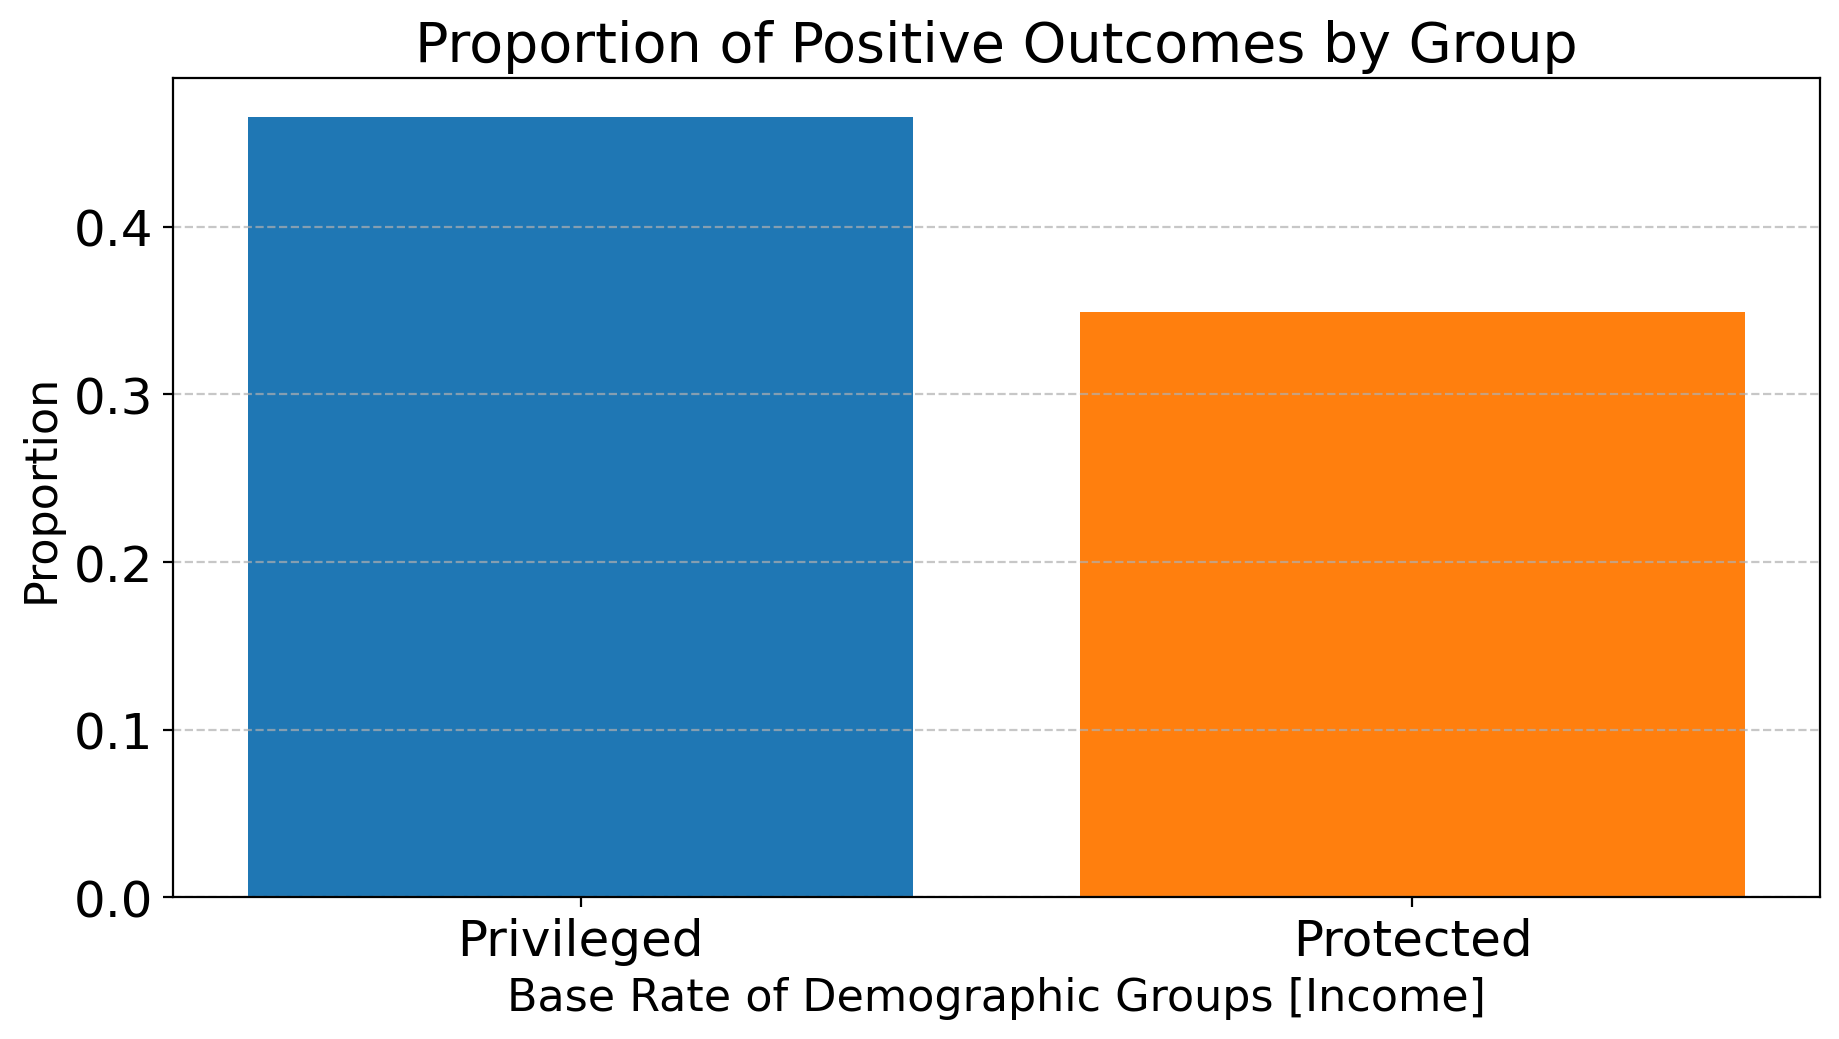

In [185]:
plt.rcParams.update({'font.size': 18, 'font.family': 'DejaVu Sans', 'figure.dpi': 200})

labels = ['Privileged', 'Protected']
values = [privileged_positive.shape[0]/privieleged_data_full.shape[0], 
          protected_positive.shape[0]/protected_data_full.shape[0]]


plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['#1f77b4', '#ff7f0e'])

plt.xlabel('Base Rate of Demographic Groups [Income]', fontsize=16)
plt.ylabel('Proportion', fontsize=16)
plt.title('Proportion of Positive Outcomes by Group', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2)
plt.show()


## First Order Influence

In [186]:
metric = 0  # spd -> 0, tpr parity -> 1, predictive parity -> 2
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]

v1 = get_del_F_del_theta(model_smart, X_test_orig, X_test, y_test, dataset_name, metric)
v1=v1.reshape(-1,1)

hessian_all_points = get_hessian_all_points(model_smart, X_train, y_train, loss_func)
del_L_del_theta = get_del_L_del_theta(model_smart, X_train, y_train, loss_func)
hinv_v, hinv = get_hinv_v(hessian_all_points, v1)
Inf_par=(1/X_train.shape[0])*(-del_L_del_theta@hinv)
Influence_loss= -np.dot(hinv, del_L_del_theta.T)
Influence_fair=Inf_par@v1

100%|██████████| 9783/9783 [00:16<00:00, 586.13it/s]


## LOO

In [187]:
'''X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
difference = []

for index in range(X_train_copy.shape[0]):
    # Duplicate the datapoint at the given index
    df_duplicated_X = np.concatenate([X_train_copy, X_train_copy[index:index+1]], axis=0)
    df_duplicated_y = np.concatenate([y_train_copy, y_train_copy[index:index+1]], axis=0)
    
    model = LogisticRegression(input_size=df_duplicated_X.shape[-1])
    model.fit(df_duplicated_X, df_duplicated_y)
    y_pred_test = model.predict_proba(X_test)
    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
    parity_diff = parity - spd_0
    difference.append(parity_diff)'''

'X_train_copy = X_train.copy()\ny_train_copy = y_train.copy()\ndifference = []\n\nfor index in range(X_train_copy.shape[0]):\n    # Duplicate the datapoint at the given index\n    df_duplicated_X = np.concatenate([X_train_copy, X_train_copy[index:index+1]], axis=0)\n    df_duplicated_y = np.concatenate([y_train_copy, y_train_copy[index:index+1]], axis=0)\n    \n    model = LogisticRegression(input_size=df_duplicated_X.shape[-1])\n    model.fit(df_duplicated_X, df_duplicated_y)\n    y_pred_test = model.predict_proba(X_test)\n    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)\n    parity_diff = parity - spd_0\n    difference.append(parity_diff)'

In [188]:
'''plt.figure(figsize=(8, 5))
plt.scatter(difference, Influence_fair, color='b', label='Influence vs Ground Truth', marker='o')
x_values = np.linspace(min(difference), max(difference), 100)
plt.plot(x_values, x_values, color='black', label='y = x', linestyle='-')


plt.xlabel('Determince influence over TD for fairness; \n Train a regressor to predict influence', fontsize=23)

plt.xticks([])
plt.yticks([])

plt.legend(fontsize=25, frameon=False)

for spine in ["top", "right", "bottom", "left"]:
    plt.gca().spines[spine].set_visible(True)

plt.tight_layout()

out_dir = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Example'
png_path = os.path.join(out_dir, "influence_function.png")
pdf_path = os.path.join(out_dir, "influence_function.pdf")

plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
plt.show()'''



'plt.figure(figsize=(8, 5))\nplt.scatter(difference, Influence_fair, color=\'b\', label=\'Influence vs Ground Truth\', marker=\'o\')\nx_values = np.linspace(min(difference), max(difference), 100)\nplt.plot(x_values, x_values, color=\'black\', label=\'y = x\', linestyle=\'-\')\n\n\nplt.xlabel(\'Determince influence over TD for fairness; \n Train a regressor to predict influence\', fontsize=23)\n\nplt.xticks([])\nplt.yticks([])\n\nplt.legend(fontsize=25, frameon=False)\n\nfor spine in ["top", "right", "bottom", "left"]:\n    plt.gca().spines[spine].set_visible(True)\n\nplt.tight_layout()\n\nout_dir = \'/Users/hasan89/Documents/Datasift_EDBT/Plot/Example\'\npng_path = os.path.join(out_dir, "influence_function.png")\npdf_path = os.path.join(out_dir, "influence_function.pdf")\n\nplt.savefig(png_path, dpi=300, bbox_inches="tight")\nplt.savefig(pdf_path, dpi=300, bbox_inches="tight")\nplt.show()'

## Second Order Influence

In [189]:
#mini_batches = get_minibatches(X_train_orig, mini_batch_size)


In [190]:
'''second_order_influences = []
v1_orig = v1

for batch in mini_batches:
    idx=batch.index
    params_f_2 = second_order_group_influence(idx, del_L_del_theta, hessian_all_points, hinv)
    del_f_2 = np.dot(v1.transpose(), params_f_2)
    second_order_influences.append(del_f_2)'''''

'second_order_influences = []\nv1_orig = v1\n\nfor batch in mini_batches:\n    idx=batch.index\n    params_f_2 = second_order_group_influence(idx, del_L_del_theta, hessian_all_points, hinv)\n    del_f_2 = np.dot(v1.transpose(), params_f_2)\n    second_order_influences.append(del_f_2)'

In [191]:
'''X_train_copy = X_train.copy()
y_train_copy = y_train.copy()'''

'X_train_copy = X_train.copy()\ny_train_copy = y_train.copy()'

## First Order ground truth check

In [192]:
'''num_batches = (X_train_copy.shape[0] + mini_batch_size - 1) // mini_batch_size
cum_group_inf=[]
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = start_index + mini_batch_size
    group_inf=Influence_fair[start_index:end_index].sum()
    cum_group_inf.append(group_inf)'''

'num_batches = (X_train_copy.shape[0] + mini_batch_size - 1) // mini_batch_size\ncum_group_inf=[]\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = start_index + mini_batch_size\n    group_inf=Influence_fair[start_index:end_index].sum()\n    cum_group_inf.append(group_inf)'

In [193]:
'''difference_group = []
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = min(start_index + mini_batch_size, X_train_copy.shape[0])  
    df_batch_X = X_train_copy[start_index:end_index]
    df_batch_y = y_train_copy[start_index:end_index]
    df_merged_X = np.concatenate((X_train_copy, df_batch_X), axis=0)
    df_merged_y = np.concatenate((y_train_copy, df_batch_y), axis=0)
    model_idx = copy.deepcopy(model_smart)
    model_idx.fit(df_merged_X, df_merged_y)
    y_pred_test = model_idx.predict_proba(X_test)
    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
    parity_diff = parity - spd_0
    difference_group.append(parity_diff)'''

'difference_group = []\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = min(start_index + mini_batch_size, X_train_copy.shape[0])  \n    df_batch_X = X_train_copy[start_index:end_index]\n    df_batch_y = y_train_copy[start_index:end_index]\n    df_merged_X = np.concatenate((X_train_copy, df_batch_X), axis=0)\n    df_merged_y = np.concatenate((y_train_copy, df_batch_y), axis=0)\n    model_idx = copy.deepcopy(model_smart)\n    model_idx.fit(df_merged_X, df_merged_y)\n    y_pred_test = model_idx.predict_proba(X_test)\n    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)\n    parity_diff = parity - spd_0\n    difference_group.append(parity_diff)'

In [194]:
'''plt.figure(figsize=(8, 6))
plt.scatter(difference_group, cum_group_inf, color='b', label='First Order Sum vs Difference_LOO', marker='o')
x_values = np.linspace(min(second_order_influences), max(second_order_influences), 100)
plt.plot(x_values, x_values, color='g', label='y = x', linestyle='-')
plt.xlabel('Difference_LOO')
plt.ylabel('Influence')
plt.title('First Order Sum vs Difference_LOO')
plt.legend()
plt.grid(True)
plt.show()'''

"plt.figure(figsize=(8, 6))\nplt.scatter(difference_group, cum_group_inf, color='b', label='First Order Sum vs Difference_LOO', marker='o')\nx_values = np.linspace(min(second_order_influences), max(second_order_influences), 100)\nplt.plot(x_values, x_values, color='g', label='y = x', linestyle='-')\nplt.xlabel('Difference_LOO')\nplt.ylabel('Influence')\nplt.title('First Order Sum vs Difference_LOO')\nplt.legend()\nplt.grid(True)\nplt.show()"

## Clustering

In [195]:
opt=find_optimal_gmm_components(datapool)

In [196]:
clustered_data=gmm_clustering(datapool, 4)

Cluster 1 shape: (80566, 11)
Cluster 2 shape: (43826, 11)
Cluster 3 shape: (15899, 11)
Cluster 4 shape: (6458, 11)


## Influence Estimation for Data Pool

## K-NN

In [197]:
'''sort_by_inf_partition = []
sort_by_inf = []
for data in clustered_data:
    sorted_cluster_data, sorted_influences_fair = sorted_influence_KNN(train_smart_df, data, Influence_fair, k=100)
    sort_by_inf_partition.append(sorted_cluster_data)
    sort_by_inf.append(sorted_influences_fair)'''

'sort_by_inf_partition = []\nsort_by_inf = []\nfor data in clustered_data:\n    sorted_cluster_data, sorted_influences_fair = sorted_influence_KNN(train_smart_df, data, Influence_fair, k=100)\n    sort_by_inf_partition.append(sorted_cluster_data)\n    sort_by_inf.append(sorted_influences_fair)'

## Regression

In [198]:
model_ridge, X_test_poly, y_test_inf= train_reg_model(train_smart_df, Influence_fair, 'Influence')

Ridge R-squared (R²): 0.9963601093210933


In [199]:
y_pred_inf = model_ridge.predict(X_test_poly)

In [200]:
'''import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(-y_pred_inf, y_test_inf, color='r',
            label='Second Order Influence vs Difference_LOO', marker='o')
plt.xlabel("Predict influence of points in partition; \n Sort descendingly ")
#plt.ylabel('Influence')
#plt.title('Prediction vs Ground Truth')
# Ignore (hide) x and y ticks + labels
ax = plt.gca()
ax.tick_params(axis='both', which='both',
               bottom=False, left=False,    # hide tick marks
               labelbottom=False, labelleft=False)  # hide tick labels


out_dir = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Example'
png_path = os.path.join(out_dir, "predict_influence.png")
pdf_path = os.path.join(out_dir, "predict_influence.pdf")
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")

png_path, pdf_path
plt.show()'''


'import matplotlib.pyplot as plt\n\nplt.figure(figsize=(8, 5))\nplt.scatter(-y_pred_inf, y_test_inf, color=\'r\',\n            label=\'Second Order Influence vs Difference_LOO\', marker=\'o\')\nplt.xlabel("Predict influence of points in partition; \n Sort descendingly ")\n#plt.ylabel(\'Influence\')\n#plt.title(\'Prediction vs Ground Truth\')\n# Ignore (hide) x and y ticks + labels\nax = plt.gca()\nax.tick_params(axis=\'both\', which=\'both\',\n               bottom=False, left=False,    # hide tick marks\n               labelbottom=False, labelleft=False)  # hide tick labels\n\n\nout_dir = \'/Users/hasan89/Documents/Datasift_EDBT/Plot/Example\'\npng_path = os.path.join(out_dir, "predict_influence.png")\npdf_path = os.path.join(out_dir, "predict_influence.pdf")\nplt.savefig(png_path, dpi=300, bbox_inches="tight")\nplt.savefig(pdf_path, bbox_inches="tight")\n\npng_path, pdf_path\nplt.show()'

## Get Sorted Data Pool

In [201]:
sorted_datapool, datapool_sorted_influences = sorted_influences_reg(datapool, model_ridge)

## Ger Sorted Cluster

In [202]:
sort_by_inf_partition = []
sort_by_inf = []
for data in clustered_data:
    sorted_cluster_data, sorted_influences = sorted_influences_reg(data, model_ridge)
    sort_by_inf_partition.append(sorted_cluster_data)
    sort_by_inf.append(sorted_influences)

## Second order cluster ground truth check

In [203]:
'''cluster_ground_truth = []
num_batches = (sort_by_inf_partition[0].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches
X_train_cl,_, y_train_cl, _, X_train_orig_cl, _= prepare_train_data(sort_by_inf_partition[0], test_orig_df, Target_attribute)
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = min(start_index + mini_batch_size, sort_by_inf_partition[0].shape[0])
    df_dropped_X = np.concatenate((X_train, X_train_cl[start_index: end_index]), axis=0)
    df_dropped_y = np.concatenate((y_train, y_train_cl[start_index: end_index]), axis=0)
    model = LogisticRegression(input_size=df_dropped_X.shape[-1])
    model_idx= copy.deepcopy(model)
    model_idx.fit(df_dropped_X, df_dropped_y)
    y_pred_test = model_idx.predict_proba(X_test)
    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
    parity_diff = parity - spd_0
    cluster_ground_truth.append(parity_diff)'''



'cluster_ground_truth = []\nnum_batches = (sort_by_inf_partition[0].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches\nX_train_cl,_, y_train_cl, _, X_train_orig_cl, _= prepare_train_data(sort_by_inf_partition[0], test_orig_df, Target_attribute)\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = min(start_index + mini_batch_size, sort_by_inf_partition[0].shape[0])\n    df_dropped_X = np.concatenate((X_train, X_train_cl[start_index: end_index]), axis=0)\n    df_dropped_y = np.concatenate((y_train, y_train_cl[start_index: end_index]), axis=0)\n    model = LogisticRegression(input_size=df_dropped_X.shape[-1])\n    model_idx= copy.deepcopy(model)\n    model_idx.fit(df_dropped_X, df_dropped_y)\n    y_pred_test = model_idx.predict_proba(X_test)\n    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)\n    parity_diff = parity - spd_0\n    cluster_ground_truth.append(parity_diff)'

In [204]:
'''num_batches = (sort_by_inf[0].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches
print(num_batches)
cum_group_inf=[]
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = start_index + mini_batch_size
    group_inf=sort_by_inf[1][start_index:end_index].sum()
    cum_group_inf.append(group_inf)'''

'num_batches = (sort_by_inf[0].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches\nprint(num_batches)\ncum_group_inf=[]\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = start_index + mini_batch_size\n    group_inf=sort_by_inf[1][start_index:end_index].sum()\n    cum_group_inf.append(group_inf)'

In [205]:
'''plt.figure(figsize=(8, 6))
plt.plot(range(1,num_batches+1), cum_group_inf, color='r', linestyle='-', label='Estimation for each mini-batch from Cluster')
plt.plot(range(1,num_batches+1), cluster_ground_truth, color='g', linestyle='-', label='Ground Truth')
plt.xlabel('Batches')
plt.ylabel('Estimated Influence for cluster')
plt.title('Ground Truth Vs Estimation')
plt.legend()
plt.grid(True)
plt.show()'''

"plt.figure(figsize=(8, 6))\nplt.plot(range(1,num_batches+1), cum_group_inf, color='r', linestyle='-', label='Estimation for each mini-batch from Cluster')\nplt.plot(range(1,num_batches+1), cluster_ground_truth, color='g', linestyle='-', label='Ground Truth')\nplt.xlabel('Batches')\nplt.ylabel('Estimated Influence for cluster')\nplt.title('Ground Truth Vs Estimation')\nplt.legend()\nplt.grid(True)\nplt.show()"

## Equal Representation

In [206]:
#protected_full_sample = protected_data_full.sample(n=int(data_acq_size/2), random_state=42)
#privileged_full_sample = privieleged_data_full.sample(n=int(data_acq_size/2), random_state=42)
#print(protected_full_sample.shape)

In [207]:
'''from copy import deepcopy

parity_differences = [ini_parity]
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for pct in percentages:
    protected_sample = protected_full_sample.sample(frac=pct, random_state=42)
    privileged_sample = privileged_full_sample.sample(n=protected_sample.shape[0], random_state=42)

    full_sample = pd.concat([protected_sample, privileged_sample])
    combined_sample_pct=pd.concat([train_smart_df, full_sample])
    
    X_train_pct, X_test_pct, y_train_pct, y_test_pct, X_train_orig_pct, X_test_orig_pct=prepare_train_data(combined_sample_pct, test_orig_df, Target_attribute)
    model_pct=LogisticRegression(input_size=X_train_pct.shape[-1])
    model_pct.fit(X_train_pct, y_train_pct)
   
    y_pred_test_pct=model_pct.predict_proba(X_test)
    parity = computeFairness(y_pred_test_pct, X_test_orig_pct, y_test_pct, 0, dataset_name)
    parity_differences.append(parity)
percentages.insert(0,0)'''

'from copy import deepcopy\n\nparity_differences = [ini_parity]\npercentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]\nfor pct in percentages:\n    protected_sample = protected_full_sample.sample(frac=pct, random_state=42)\n    privileged_sample = privileged_full_sample.sample(n=protected_sample.shape[0], random_state=42)\n\n    full_sample = pd.concat([protected_sample, privileged_sample])\n    combined_sample_pct=pd.concat([train_smart_df, full_sample])\n    \n    X_train_pct, X_test_pct, y_train_pct, y_test_pct, X_train_orig_pct, X_test_orig_pct=prepare_train_data(combined_sample_pct, test_orig_df, Target_attribute)\n    model_pct=LogisticRegression(input_size=X_train_pct.shape[-1])\n    model_pct.fit(X_train_pct, y_train_pct)\n   \n    y_pred_test_pct=model_pct.predict_proba(X_test)\n    parity = computeFairness(y_pred_test_pct, X_test_orig_pct, y_test_pct, 0, dataset_name)\n    parity_differences.append(parity)\npercentages.insert(0,0)'

In [208]:
'''parity_differences_equal = [ini_parity]
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for pct in percentages:
    protected_sample = protected_full_sample.sample(frac=pct, random_state=42)
    privileged_sample = privileged_full_sample.sample(n=protected_sample.shape[0], random_state=42)-int(((privieleged_data_full_train.shape[0]-protected_data_full_train.shape[0]))/5)
    full_sample = pd.concat([protected_sample, privileged_sample])
    combined_sample_pct=pd.concat([train_smart_df, full_sample])
    
    X_train_pct, X_test_pct, y_train_pct, y_test_pct, X_train_orig_pct, X_test_orig_pct=prepare_train_data(combined_sample_pct, test_orig_df, Target_attribute)
    model_pct=LogisticRegression(input_size=X_train_pct.shape[-1])
    model_pct.fit(X_train_pct, y_train_pct)
   
    y_pred_test_pct=model_pct.predict_proba(X_test)
    parity = computeFairness(y_pred_test_pct, X_test_orig_pct, y_test_pct, 0, dataset_name)
    parity_differences_equal.append(parity)
percentages.insert(0,0)'''

'parity_differences_equal = [ini_parity]\npercentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]\n\nfor pct in percentages:\n    protected_sample = protected_full_sample.sample(frac=pct, random_state=42)\n    privileged_sample = privileged_full_sample.sample(n=protected_sample.shape[0], random_state=42)-int(((privieleged_data_full_train.shape[0]-protected_data_full_train.shape[0]))/5)\n    full_sample = pd.concat([protected_sample, privileged_sample])\n    combined_sample_pct=pd.concat([train_smart_df, full_sample])\n    \n    X_train_pct, X_test_pct, y_train_pct, y_test_pct, X_train_orig_pct, X_test_orig_pct=prepare_train_data(combined_sample_pct, test_orig_df, Target_attribute)\n    model_pct=LogisticRegression(input_size=X_train_pct.shape[-1])\n    model_pct.fit(X_train_pct, y_train_pct)\n   \n    y_pred_test_pct=model_pct.predict_proba(X_test)\n    parity = computeFairness(y_pred_test_pct, X_test_orig_pct, y_test_pct, 0, dataset_name)\n    parity_differences_equal.append(

In [209]:
'''table_eq = {
    'Acquired Data Percentages of Budget (%)': [int(pct * 100) for pct in percentages],
    'Fairness Metric': parity_differences
}

table = pd.DataFrame(table_eq)
table['Acquired Data Percentages of Budget (%)'] = table['Acquired Data Percentages of Budget (%)'].apply(lambda x: f'{x}%')
table.iloc[0, 0] = 'Initial'
table['Fairness Metric'] = table['Fairness Metric'].round(2)
file_path = os.path.join(folder_path, "fairness_metric_table_uneq_train.jpg")

plt.figure(figsize=(8, 1.8))
plt.table(cellText=table.values, colLabels=table.columns, cellLoc='center', loc='center', colColours=["lightblue"]*2)
plt.axis('off')
plt.title('Training Data has Imbalance Representation(Equal Representation)')

#plt.savefig(file_path, format='jpg', bbox_inches='tight', dpi=600)

plt.show()'''

'table_eq = {\n    \'Acquired Data Percentages of Budget (%)\': [int(pct * 100) for pct in percentages],\n    \'Fairness Metric\': parity_differences\n}\n\ntable = pd.DataFrame(table_eq)\ntable[\'Acquired Data Percentages of Budget (%)\'] = table[\'Acquired Data Percentages of Budget (%)\'].apply(lambda x: f\'{x}%\')\ntable.iloc[0, 0] = \'Initial\'\ntable[\'Fairness Metric\'] = table[\'Fairness Metric\'].round(2)\nfile_path = os.path.join(folder_path, "fairness_metric_table_uneq_train.jpg")\n\nplt.figure(figsize=(8, 1.8))\nplt.table(cellText=table.values, colLabels=table.columns, cellLoc=\'center\', loc=\'center\', colColours=["lightblue"]*2)\nplt.axis(\'off\')\nplt.title(\'Training Data has Imbalance Representation(Equal Representation)\')\n\n#plt.savefig(file_path, format=\'jpg\', bbox_inches=\'tight\', dpi=600)\n\nplt.show()'

## Algorithms

## DataSift_MAB

In [210]:
tau=0.01

In [211]:
Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=20, tau=tau, budget=data_acq_size, alpha=0.1, beta=1)

## DataSift

In [212]:
MAB_inf_update_data, MAB_inf_iteration_count, MAB_inf_iteration_count_ex, MAB_inf_parity_ex, stat_MAB_inf, MAB_inf_accuracy_ex, MAB_inf_time_per_iteration, MAB_inf_cluster_count, iteration_time_MAB_inf = mab_inf_algorithm(sort_by_inf_partition, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=20, tau=tau, budget=data_acq_size, alpha=0.1, beta=1)

## AutoData

In [213]:
normalized_distance=compute_normalized_distances(clustered_data)

In [214]:
Stat_update_data_dist, i_values_stat_dist, i_values_ex_stat_dist, stat_ex_dist, stat_dist, acc_stat_dist, time_per_iteration_stat_dist, cluster_count_dist, iteration_time1_dist = mab_algorithm_dist(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=30, tau=tau, budget=data_acq_size, Euclid_normalized_d=normalized_distance, alpha=0.1)

## Random Acquisition

In [215]:
data_random, i_values_ex_ran, i_values_ran, stat_ran, stat_ex_ran, acc_ran, time_per_iteration_ran =random_algorithm(datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=tau, budget=data_acq_size)

## Entropy

In [216]:
data_entropy, i_values_ex_ent, i_values_ent, stat_ent, stat_ex_ent, acc_ent, time_per_iteration_ent =entropy_based_algorithm(datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=tau, budget=data_acq_size)

## Only Influence

In [217]:
data_inf, i_values_ex_inf, i_values_inf, stat_inf, stat_ex_inf, acc_inf, time_per_iteration_inf =inf_algorithm(sorted_datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=tau, budget=data_acq_size)

## Uniform

In [219]:
'''import matplotlib.ticker as mticker

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(8, 6))
#plt.plot(percentages, stat_ran, marker='s', color='b', label='ImBalance Training Data')
#plt.plot(percentages, stat_ran_eq, marker='s', color='b', label='Balanced TD: Random Acquisition')
plt.plot(percentages, stat_ran, marker='s', color='r', label='Imbalanced TD: Random Acquisition')
#plt.plot(percentages, parity_differences_eq, marker='s', color='lightblue', label='Balanced TD: Equal Representation')
plt.plot(percentages, parity_differences, marker='s', color='orange', label='Imbalanced TD: Equal Representation')

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
plt.xlabel('Acquired Data Percentages of Budget')
plt.ylabel('Fairness Metric')
plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.05))

plt.savefig(file_path, format='pdf', dpi=600)'''

"import matplotlib.ticker as mticker\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\nplt.figure(figsize=(8, 6))\n#plt.plot(percentages, stat_ran, marker='s', color='b', label='ImBalance Training Data')\n#plt.plot(percentages, stat_ran_eq, marker='s', color='b', label='Balanced TD: Random Acquisition')\nplt.plot(percentages, stat_ran, marker='s', color='r', label='Imbalanced TD: Random Acquisition')\n#plt.plot(percentages, parity_differences_eq, marker='s', color='lightblue', label='Balanced TD: Equal Representation')\nplt.plot(percentages, parity_differences, marker='s', color='orange', label='Imbalanced TD: Equal Representation')\n\nplt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))\nplt.xlabel('Acquired Data Percentages of Budget')\nplt.ylabel('Fairness Metric')\nplt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.05))\n\nplt.savefig(file_path, format='pdf', dpi=600)"

In [220]:
'''table_eq = {
    'Acquired Data Percentages of Budget (%)': [int(pct * 100) for pct in percentages],
    'Fairness Metric': stat_ran
}

table = pd.DataFrame(table_eq)
table['Acquired Data Percentages of Budget (%)'] = table['Acquired Data Percentages of Budget (%)'].apply(lambda x: f'{x}%')
table.iloc[0, 0] = 'Initial'
table['Fairness Metric'] = table['Fairness Metric'].round(2)
file_path = os.path.join(folder_path, "fairness_metric_table_ran_uneq_train.jpg")

plt.figure(figsize=(8, 1.8))
plt.table(cellText=table.values, colLabels=table.columns, cellLoc='center', loc='center', colColours=["lightblue"]*2)
plt.axis('off')
plt.title('Training Data has Imbalance Representation(Random)')

plt.savefig(file_path, format='jpg', bbox_inches='tight', dpi=600)

plt.show()'''

'table_eq = {\n    \'Acquired Data Percentages of Budget (%)\': [int(pct * 100) for pct in percentages],\n    \'Fairness Metric\': stat_ran\n}\n\ntable = pd.DataFrame(table_eq)\ntable[\'Acquired Data Percentages of Budget (%)\'] = table[\'Acquired Data Percentages of Budget (%)\'].apply(lambda x: f\'{x}%\')\ntable.iloc[0, 0] = \'Initial\'\ntable[\'Fairness Metric\'] = table[\'Fairness Metric\'].round(2)\nfile_path = os.path.join(folder_path, "fairness_metric_table_ran_uneq_train.jpg")\n\nplt.figure(figsize=(8, 1.8))\nplt.table(cellText=table.values, colLabels=table.columns, cellLoc=\'center\', loc=\'center\', colColours=["lightblue"]*2)\nplt.axis(\'off\')\nplt.title(\'Training Data has Imbalance Representation(Random)\')\n\nplt.savefig(file_path, format=\'jpg\', bbox_inches=\'tight\', dpi=600)\n\nplt.show()'

## DataSift Vs Others

## SliceTuner

In [221]:
slice_adult=[spd_0, 
 -0.14,
 -0.16567,
 -0.17565,
 -0.17565,
 -0.17565,
 -0.18962,
 -0.17964,
 -0.18762,
 -0.18563,
 -0.18762]
slice_income=[spd_0,
 -0.36527,
 -0.29940,
 -0.25948,
 -0.24351,
 -0.23553,
 -0.21756,
 -0.20559,
 -0.185,
 -0.17565,
 -0.18563]
slice_income_svm=[spd_0, -0.36924152, -0.30740519, -0.23149701, -0.21948104,
       -0.23552894, -0.2255489 , -0.19161677, -0.17964072, -0.18363273,
       -0.16367265]
slice_income_nn=[spd_0, -0.32924152, -0.26740519, -0.23149701, -0.21948104,
       -0.23552894, -0.2355489 , -0.19161677, -0.17964072, -0.18363273,
       -0.16367265]
slice_public=[spd_0,
 -0.5884231536926148,
 -0.5700598802395209,
 -0.469061876247505,
 -0.4483033932135728,
 -0.33612774451097804,
 -0.3520958083832335,
 -0.3445109780439121,
 -0.341317365269461,
 -0.2906187624750499,
 -0.17245508982035926]
slice_employment=[spd_0,
 -0.31776447105788425,
 -0.30019960079840324,
 -0.27225548902195607,
 -0.2379241516966068,
 -0.2415169660678643,
 -0.22475049900199603,
 -0.21117764471057887,
 -0.17245508982035926,
 -0.180439121756487,
 -0.20039920159680635]
slice_mobility=[spd_0,
 -0.17325349301397205,
 -0.1544910179640719,
 -0.12175648702594813,
 -0.11576846307385227,
 -0.10259481037924152,
 -0.10618762475049899,
 -0.11337325349301401,
 -0.10738522954091816,
 -0.11497005988023953,
 -0.09980039920159682]
slice_credit=[spd_0,
 -0.06307385229540917,
 -0.030738522954091817,
 -0.04431137724550898,
 -0.033932135728542916,
 -0.021556886227544914,
 -0.017564870259481037,
 -0.02994011976047904,
 -0.013572854291417163,
 -0.017564870259481037,
 -0.015568862275449102]


## DataSift-Inf

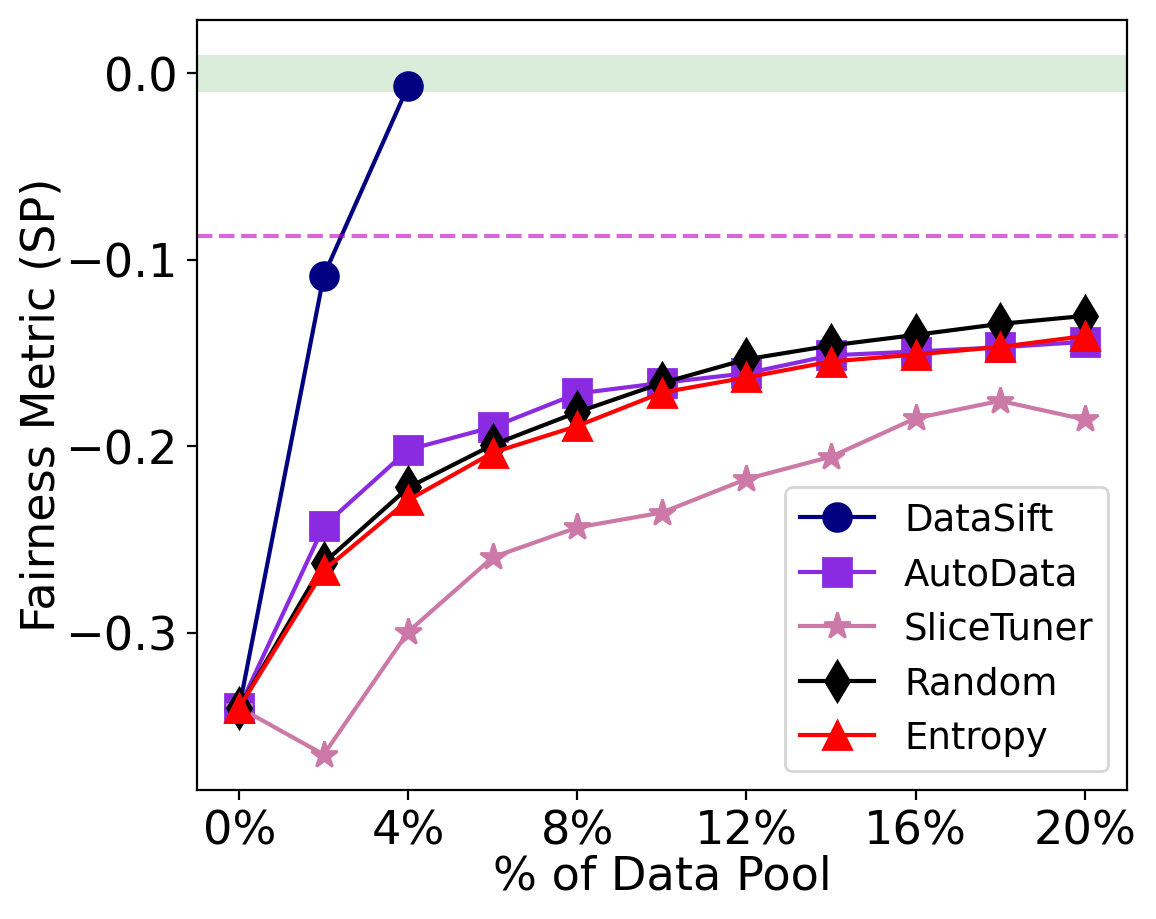

In [222]:
import pylab as plot
import matplotlib

# --- Style (same as your percentile-style figure) ---
fsize = 20
params = {'legend.fontsize': fsize, 'legend.handlelength': 2}
plot.rcParams.update(params)

font = {'family': "sans serif", 'size': fsize}
matplotlib.rc('font', **font)

# --- Save path ---
folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/DataSift_vs_Basleines'
file_name = f"{dataset_name}_{model}.pdf"

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ... your existing code above ...

plt.figure(figsize=(6, 5))
plt.xticks(fontsize=fsize/1.2)
plt.yticks(fontsize=fsize/1.2)

# === add the red ±0.01 fairness band ===
ax = plt.gca()
ax.axhspan(-0.01, 0.01, facecolor='g', alpha=0.15, zorder=0)  # shaded region

x_inf_ds = [i for i in MAB_inf_iteration_count_ex if i % 1 == 0]
y_inf_ds = [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in x_inf_ds]
plt.plot(x_inf_ds, y_inf_ds,
         marker='o', linestyle='-', color='navy', markersize=10,
         label='DataSift')

# AutoData
x_ad = [i for i in i_values_ex_stat_dist if i % 1 == 0]
y_ad = [stat_ex_dist[i_values_ex_stat_dist.index(i)] for i in x_ad]
plt.plot(x_ad, y_ad, marker='s', linestyle='-', color='blueviolet', markersize=10, label='AutoData')

#SliceTuner
x_ad = [i for i in i_values_ex_ran if i % 1 == 0]
y_ad = [slice_income[i_values_ex_ran.index(i)] for i in x_ad]
plt.plot(x_ad, y_ad, marker='*', linestyle='-', color="#CC79A7", markersize=10, label='SliceTuner')

# Random
x_rn = [i for i in i_values_ex_ran if i % 1 == 0]
y_rn = [stat_ex_ran[i_values_ex_ran.index(i)] for i in x_rn]
plt.plot(x_rn, y_rn, marker='d', linestyle='-', color='black', markersize=10, label='Random')

# Entropy
x_en = [i for i in i_values_ex_ent if i % 1 == 0]
y_en = [stat_ex_ent[i_values_ex_ent.index(i)] for i in x_en]
plt.plot(x_en, y_en, marker='^', linestyle='-', color='red', markersize=10, label='Entropy')

# Reference line & axes formatting
plt.axhline(y=full_parity, color='m', alpha=0.6, linestyle='--')

ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / datapool.shape[0]) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Data Pool', labelpad=0, fontsize=fsize/1.2)
plt.ylabel('Fairness Metric (SP)', labelpad=0, fontsize=fsize/1.2)
plt.legend(fontsize=fsize/1.5, loc='best', ncol=1)
plt.tick_params(axis='both', which='major', labelsize=fsize/1.2)

#plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
plt.show()



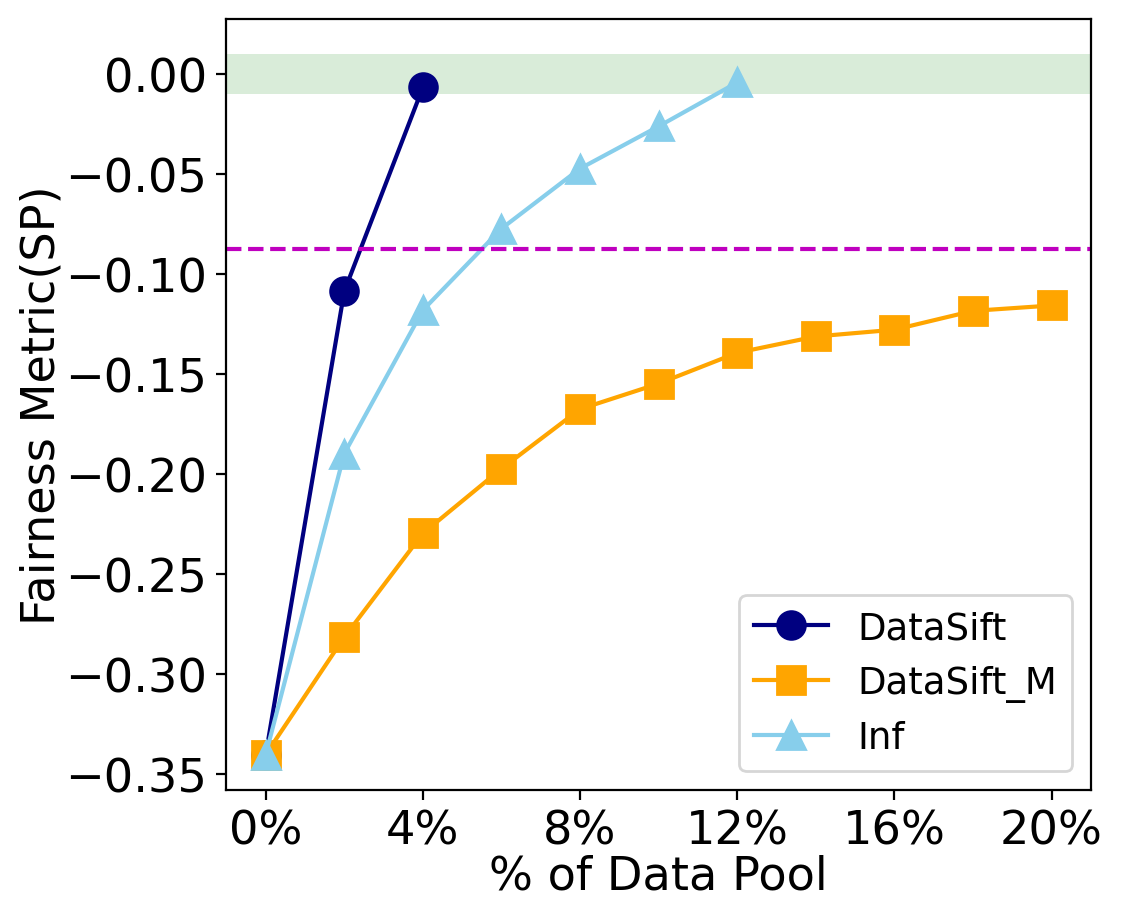

In [223]:
import pylab as plot
import matplotlib

# --- Style (same as your percentile-style figure) ---
fsize = 20
params = {'legend.fontsize': fsize, 'legend.handlelength': 2}
plot.rcParams.update(params)

font = {'family': "sans serif", 'size': fsize}
matplotlib.rc('font', **font)

# --- Save path ---
folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/DataSift_vs_diff'
file_name = f"{dataset_name}_{model}.pdf"

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(6, 5))
plt.xticks(fontsize=fsize/1.2)
plt.yticks(fontsize=fsize/1.2)

ax = plt.gca()
ax.axhspan(-0.01, 0.01, facecolor='g', alpha=0.15, zorder=0)  # shaded region

x_inf_ds = [i for i in MAB_inf_iteration_count_ex if i % 1 == 0]
y_inf_ds = [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in x_inf_ds]
plt.plot(x_inf_ds, y_inf_ds,
         marker='o', linestyle='-', color='navy', markersize=10,
         label='DataSift')

# Inf  (red star)
x_inf = [i for i in i_values_ex_stat if i % 1 == 0]
y_inf = [stat_ex[i_values_ex_stat.index(i)] for i in x_inf]
plt.plot(x_inf, y_inf,
         marker='s', linestyle='-', color='orange', markersize=10,
         label='DataSift_M')

x_inf = [i for i in i_values_ex_inf if i % 1 == 0]
y_inf = [stat_ex_inf[i_values_ex_inf.index(i)] for i in x_inf]
plt.plot(x_inf, y_inf,
         marker='^', linestyle='-', color='skyblue', markersize=10,
         label='Inf')



# --- Reference line & axes formatting ---
plt.axhline(y=full_parity, color='m', alpha=1, linestyle='--')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / datapool.shape[0]) * 100, 100):.0f}%'
    )
)
#plt.xticks([1,2,3,4,5,6,7,8,9,10], ['2', '20','30', '40', '50', '60', '70', '80', '90', '100'])
plt.xlabel('% of Data Pool', labelpad=0, fontsize=fsize/1.2)
plt.ylabel('Fairness Metric(SP)', labelpad=0, fontsize=fsize/1.2)
plt.legend(fontsize=fsize/1.5, loc='best', ncol=1)
plt.tick_params(axis='both', which='major', labelsize=fsize/1.2)

plt.tight_layout()  # optional, kept off to mirror your prior style#plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
#plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
plt.show()

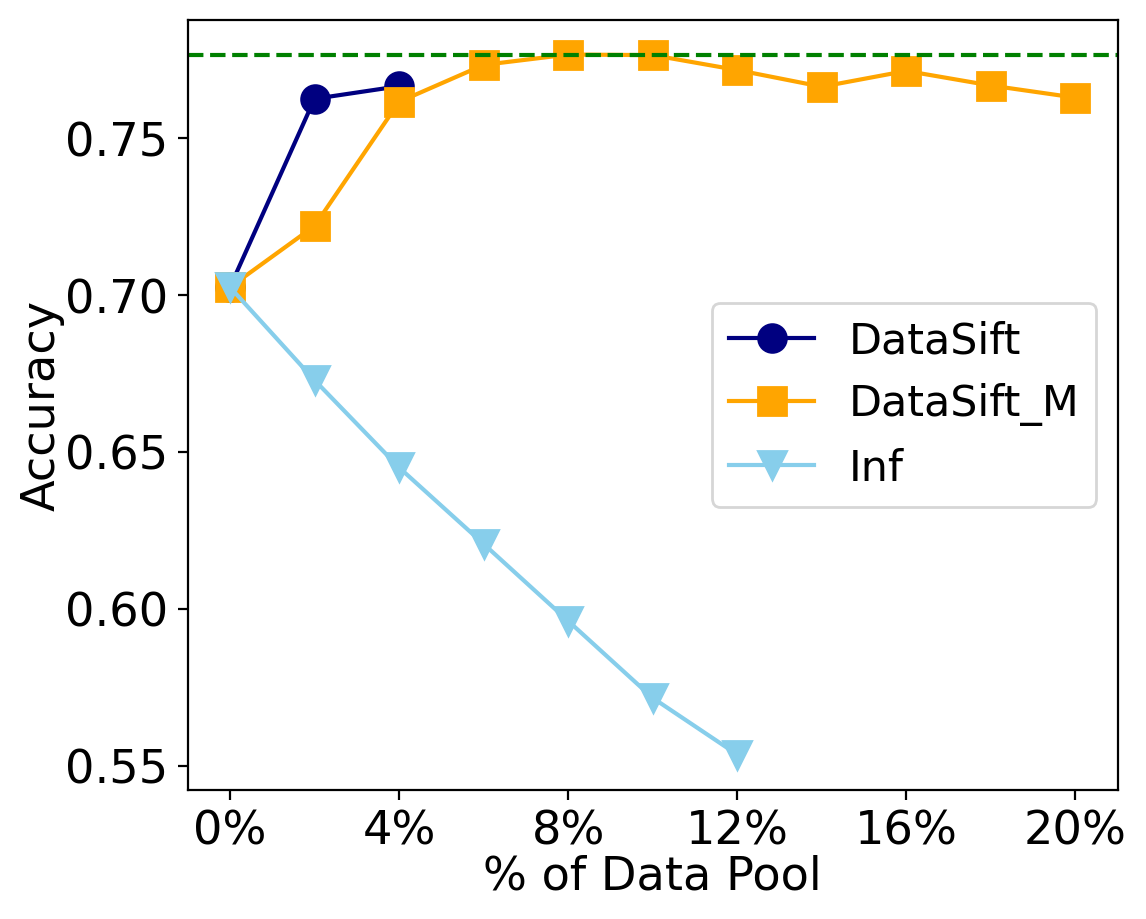

In [224]:
import pylab as plot
import matplotlib

# --- Style (same as your percentile-style figure) ---
fsize = 20
params = {'legend.fontsize': fsize, 'legend.handlelength': 2}
plot.rcParams.update(params)

font = {'family': "sans serif", 'size': fsize}
matplotlib.rc('font', **font)

# --- Save path ---
folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/DataSift_vs_Basleines'
file_name = f"{dataset_name}_{model}_Acc.pdf"

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(6, 5))
plt.xticks(fontsize=fsize/1.2)
plt.yticks(fontsize=fsize/1.2)

#DataSift
x_inf_ds = [i for i in MAB_inf_iteration_count_ex if i % 1 == 0]
y_inf_ds = [MAB_inf_accuracy_ex[MAB_inf_iteration_count_ex.index(i)] for i in x_inf_ds]
plt.plot(x_inf_ds, y_inf_ds,
         marker='o', linestyle='-', color='navy', markersize=10,
         label='DataSift')

x_inf = [i for i in i_values_ex_stat if i % 1 == 0]
y_inf = [acc_stat[i_values_ex_stat.index(i)] for i in x_inf]
plt.plot(x_inf, y_inf,
         marker='s', linestyle='-', color='orange', markersize=10,
         label='DataSift_M')

# Inf  (red star)
x_inf = [i for i in i_values_ex_inf if i % 1 == 0]
y_inf = [acc_inf[i_values_ex_inf.index(i)] for i in x_inf]
plt.plot(x_inf, y_inf,
         marker='v', linestyle='-', color='skyblue', markersize=10,
         label='Inf')

# --- Reference line & axes formatting ---
plt.axhline(y=ini_acc, color='g', alpha=1, linestyle='--')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / datapool.shape[0]) * 100, 100):.0f}%'
    )
)
#plt.xticks([1,2,3,4,5,6,7,8,9,10], ['2', '20','30', '40', '50', '60', '70', '80', '90', '100'])
plt.xlabel('% of Data Pool', labelpad=0, fontsize=fsize/1.2)
plt.ylabel('Accuracy', labelpad=0, fontsize=fsize/1.2)
plt.legend(fontsize=fsize/1.3, loc='best', ncol=1)
plt.tick_params(axis='both', which='major', labelsize=fsize/1.2)

# plt.tight_layout()  # optional, kept off to mirror your prior style
#plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Budget Exploitation

In [225]:
DS=[1, 1, 1, 1, 1, .4]
DS=[.6, .45, .3, .5, .3, .3]
DS_1=[1,.6]
DS_2=[1, .45]
DS_3= [1, .3]
DS_4= [1, .5]
DS_5=[1, .3]
DS_6=[.4, .3]
datasets = ['Adult Income', 'ACS Income', 'Employment', 'Public Health', 'Mobility', 'Credit']

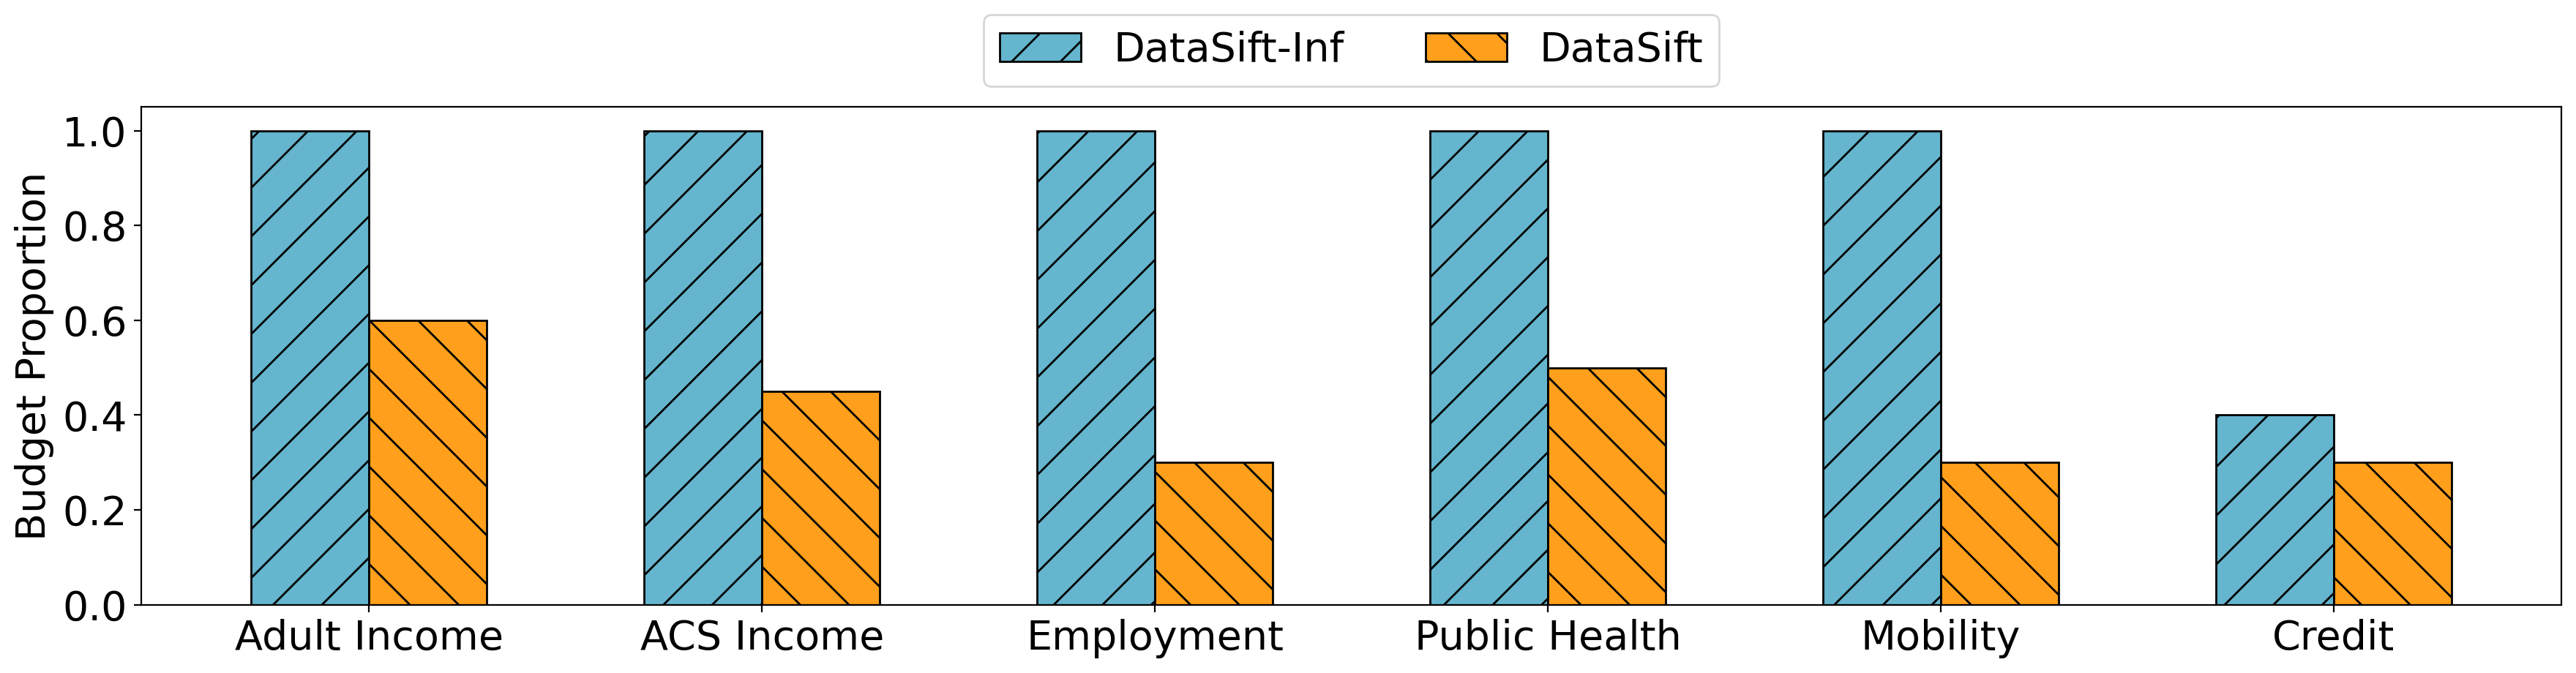

In [226]:
folder_path = '/Users/hasan89/Documents/Plot_Revision/Efficiency'
file_name = 'budget.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

datasets = ['Adult Income', 'ACS Income', 'Employment', 'Public Health', 'Mobility', 'Credit']

methods = ['DataSift-Inf', 'DataSift']
colors = ['#64B5CD', '#FF9F1C']


required_budget = [DS_1, DS_2, DS_3, 
                  DS_4, DS_5, DS_6]


hatch_patterns = ['/', '\\', '*', '\-', 'o', 'x']


n_datasets = len(datasets)
n_methods = len(methods)


bar_width = 0.15
gap = 0.2
index = np.arange(n_datasets) * (n_methods * bar_width + gap) 


plt.figure(figsize=(18, 5))


for i, (method, color, hatch) in enumerate(zip(methods, colors, hatch_patterns)):
    plt.bar(index + i * bar_width, [time[i] for time in required_budget], 
            bar_width, label=method, color=color, edgecolor='black', hatch=hatch)




plt.ylabel('Budget Proportion', fontsize=20)
plt.xticks(index + bar_width * (n_methods - 1) / 2, datasets, fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1), loc='lower center', ncol=n_methods)



plt.gca().set_facecolor('white')
plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=600)
plt.show()



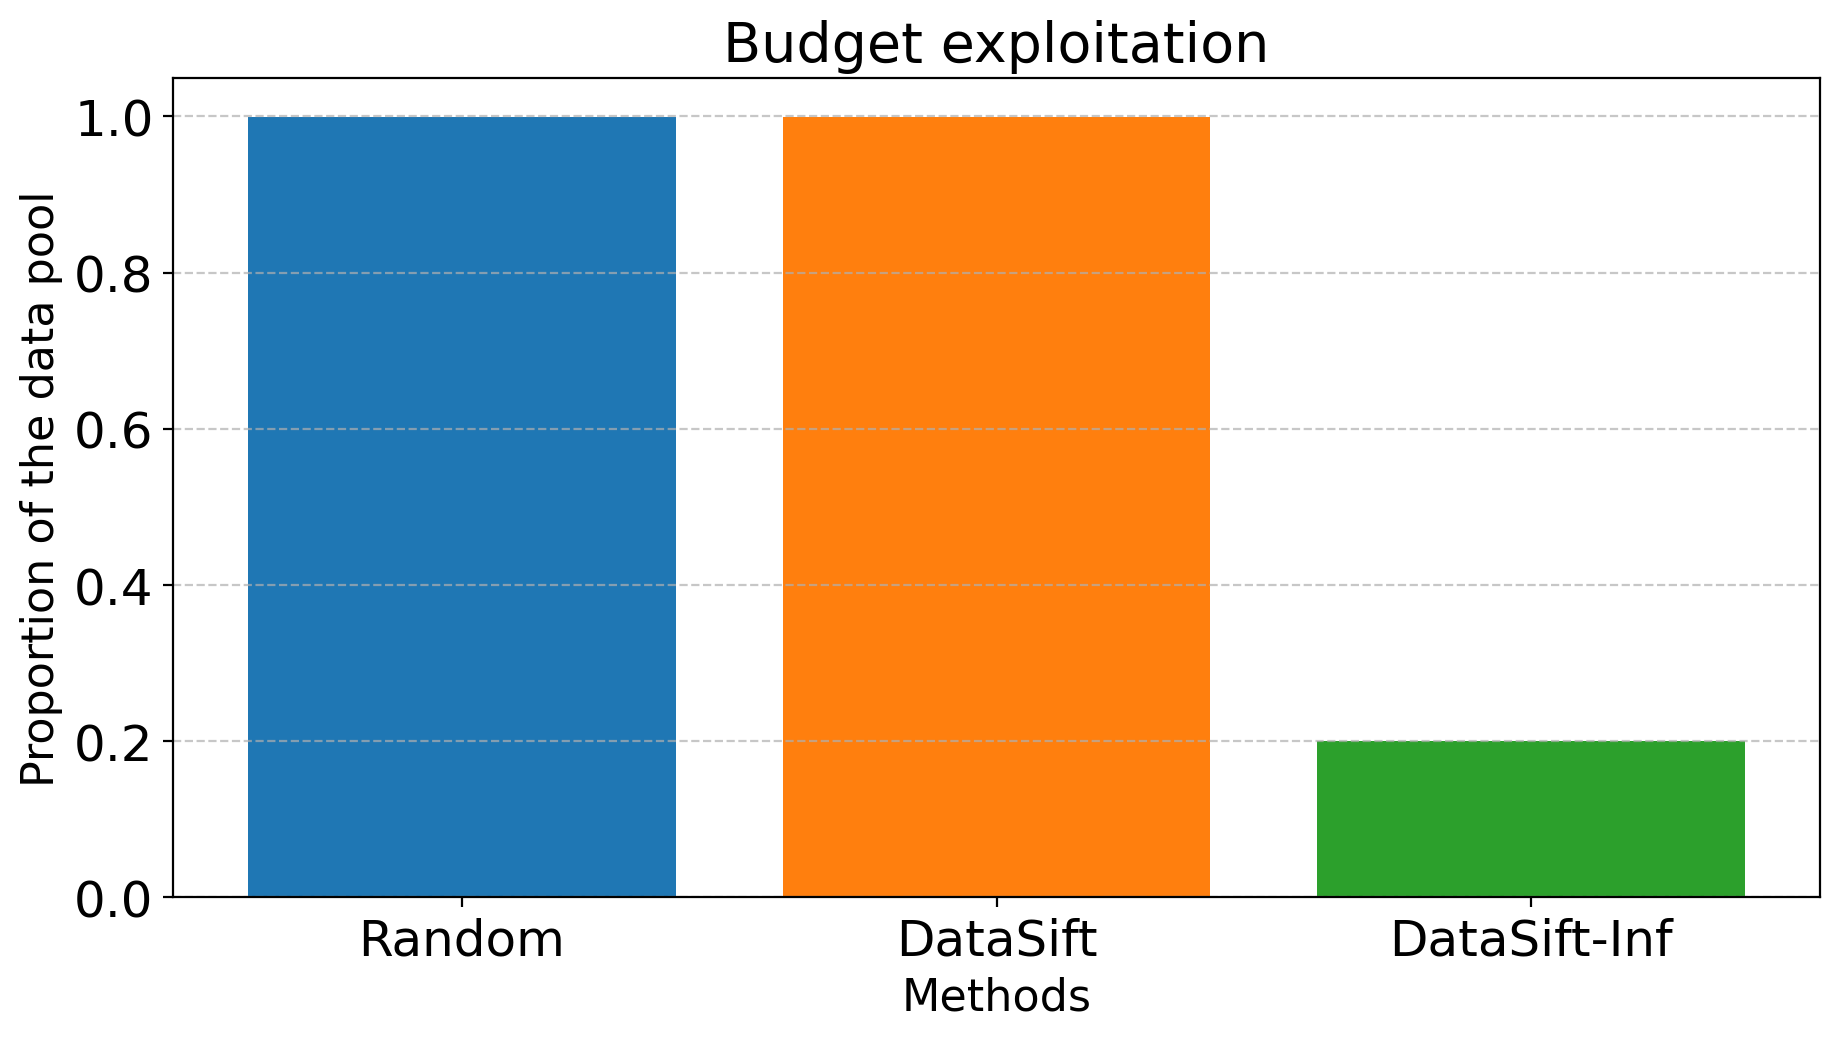

In [227]:
plt.rcParams.update({'font.size': 18, 'font.family': 'DejaVu Sans', 'figure.dpi': 200})

labels = ['Random', 'DataSift', 'DataSift-Inf']
values = [(data_random.shape[0]-train_smart_df.shape[0])/data_acq_size, (Stat_update_data.shape[0]-train_smart_df.shape[0])/data_acq_size, (MAB_inf_update_data.shape[0]-train_smart_df.shape[0])/data_acq_size]


plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])


plt.xlabel('Methods', fontsize=16)
plt.ylabel('Proportion of the data pool', fontsize=16)
plt.title('Budget exploitation', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2)
plt.show()

## Partition Selection frequency

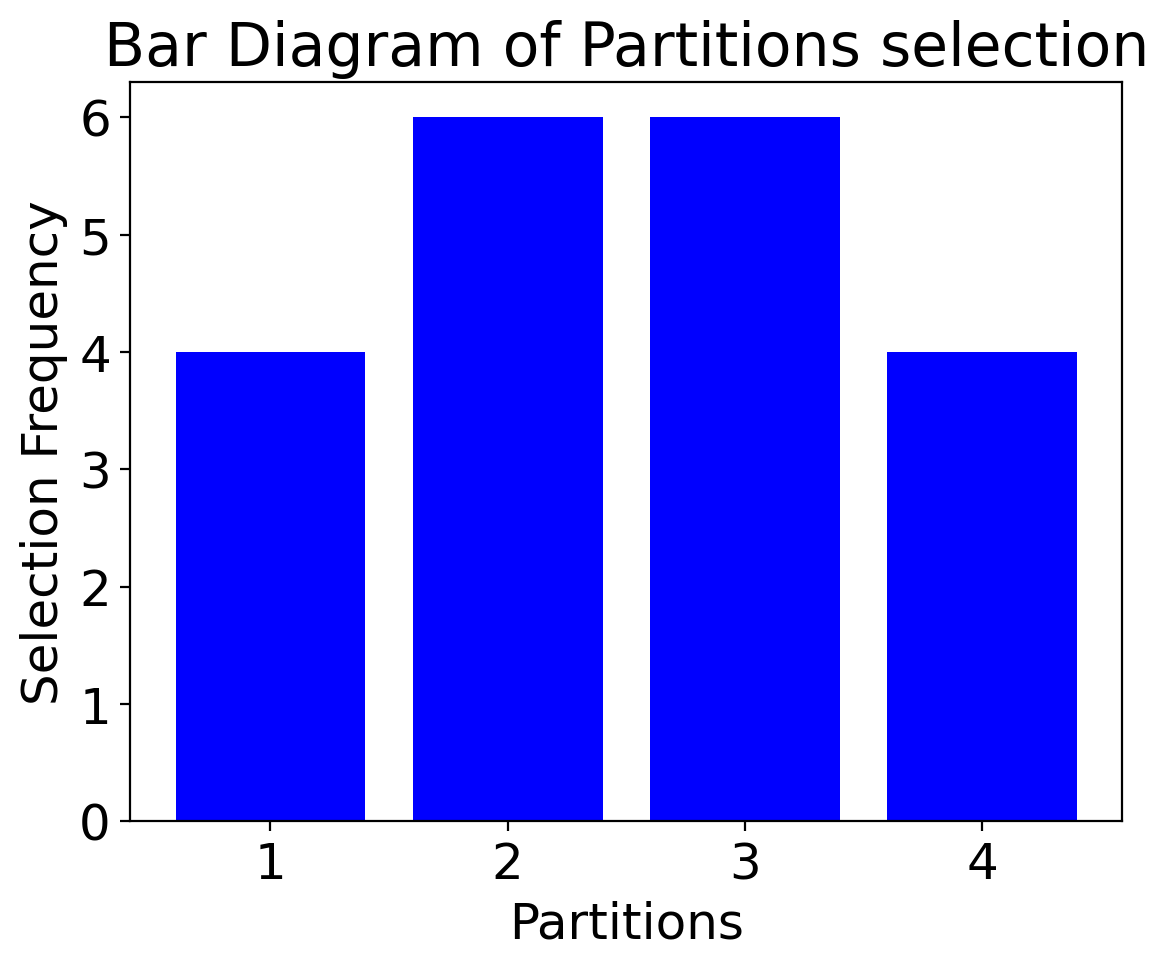

In [228]:
plt.figure(2)
data = cluster_count
counter = Counter(data)

numbers = list(counter.keys())
frequencies = list(counter.values())

plt.bar(numbers, frequencies, color='blue')
plt.xlabel('Partitions')
plt.ylabel('Selection Frequency')
plt.title('Bar Diagram of Partitions selection')

plt.show()

## Efficiency

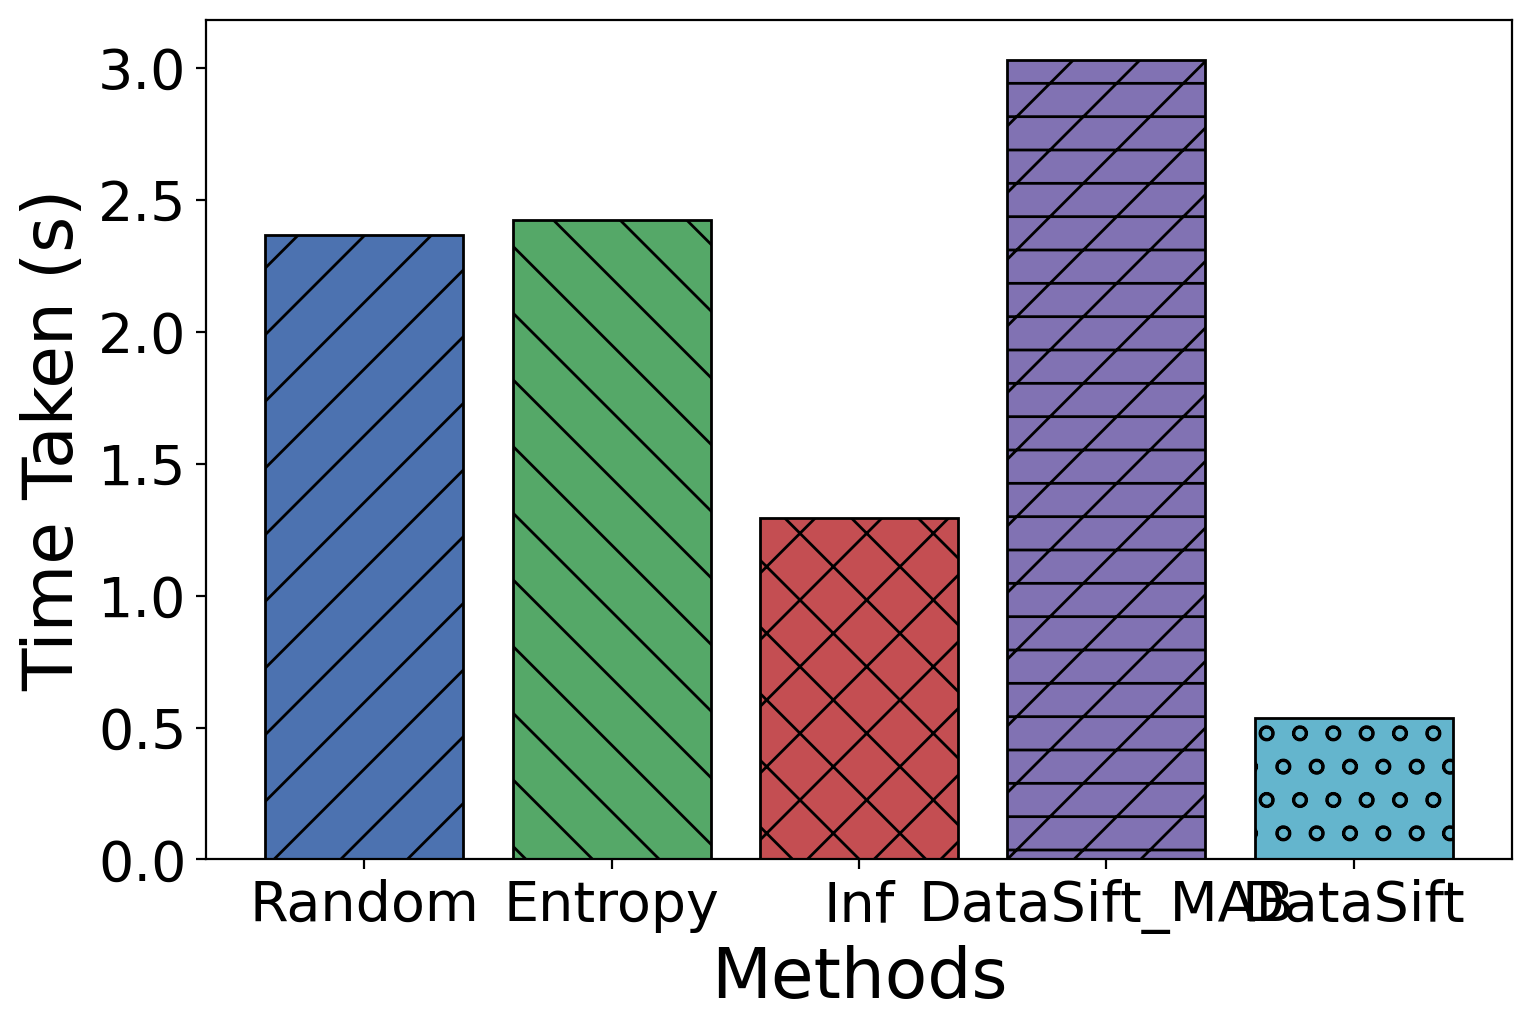

In [229]:
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Efficiency'
file_name = 'public.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

methods = ['Random', 'Entropy','Inf', 'DataSift_MAB', 'DataSift']
required_tme = [time_per_iteration_ran, time_per_iteration_ent, time_per_iteration_inf, iteration_time1, iteration_time_MAB_inf]

plt.figure(figsize=(8, 5.5))

hatch_patterns = ['/', '\\', 'x', '/-', 'o']
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#64B5CD']

bars = plt.bar(methods, required_tme, color=colors, edgecolor='black', linewidth=1, hatch=hatch_patterns)


plt.xlabel('Methods', fontsize=25)
plt.ylabel('Time Taken (s)', fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.gca().set_facecolor('white')

plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=600)
plt.show()


## reward selection method

In [230]:

'''fsize = 20
params = {'legend.fontsize': fsize, 'legend.handlelength': 2}
plot.rcParams.update(params)

font = {'family': "sans serif", 'size': fsize}
matplotlib.rc('font', **font)
folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Ablation'
file_name = f"{dataset_name}_{model}_partition_new.pdf"

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Patch

plt.figure(figsize=(6, 5))
plt.xticks(fontsize=fsize/1.2)
plt.yticks(fontsize=fsize/1.2)

methods = ['DS-Clusters', 'DS-States','DS-Stratified']
required_tme = [4, 6, 16]
hatch_patterns = ['/', '\\', 'x']
colors = [ '#FF9F1C', '#4C72B0', '#55A868', '#C44E52']

x = range(len(methods))
bars = plt.bar(x, required_tme, color=colors, edgecolor='black', linewidth=1)

for b, h in zip(bars, hatch_patterns):
    b.set_hatch(h)
ax = plt.gca()
ax.set_xticks([])
ax.set_xticklabels([])

ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

legend_handles = [
    Patch(facecolor=colors[i], edgecolor='black', hatch=hatch_patterns[i], label=methods[i])
    for i in range(len(methods))
]
plt.legend(handles=legend_handles, loc='upper left', frameon=False, fontsize=20)

plt.ylabel('% of Data Pool', fontsize=20)

plt.xticks(fontsize=fsize/1.2)
plt.yticks(fontsize=fsize/1.2)

plt.gca().set_facecolor('white')

plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
plt.show()'''





'fsize = 20\nparams = {\'legend.fontsize\': fsize, \'legend.handlelength\': 2}\nplot.rcParams.update(params)\n\nfont = {\'family\': "sans serif", \'size\': fsize}\nmatplotlib.rc(\'font\', **font)\nfolder_path = \'/Users/hasan89/Documents/Datasift_EDBT/Plot/Ablation\'\nfile_name = f"{dataset_name}_{model}_partition_new.pdf"\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\nimport os\nimport matplotlib.pyplot as plt\nimport matplotlib.ticker as mticker\nfrom matplotlib.patches import Patch\n\nplt.figure(figsize=(6, 5))\nplt.xticks(fontsize=fsize/1.2)\nplt.yticks(fontsize=fsize/1.2)\n\nmethods = [\'DS-Clusters\', \'DS-States\',\'DS-Stratified\']\nrequired_tme = [4, 6, 16]\nhatch_patterns = [\'/\', \'\\\', \'x\']\ncolors = [ \'#FF9F1C\', \'#4C72B0\', \'#55A868\', \'#C44E52\']\n\nx = range(len(methods))\nbars = plt.bar(x, required_tme, color=colors, edgecolor=\'black\', linewidth=1)\n\nfor b, h in zip(bars, hatch_patterns):\n    b.set_hatch(h)\n

In [231]:
'''methods=['Random', 'Entrophy', 'Uniform', 'Waterfilling']
fairness=[-.114, -.11, -.123, -.108]
accuracy=[.78, .78, .76, .74]'''

"methods=['Random', 'Entrophy', 'Uniform', 'Waterfilling']\nfairness=[-.114, -.11, -.123, -.108]\naccuracy=[.78, .78, .76, .74]"

In [232]:
'''import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Example'
file_name = f"adult_LR.pdf"

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

methods = ['Initial','Entire datapool', 'Random', 'Uniform', 'Waterfilling']
fairness = np.array([-.17, -.18,  -.18, -.11, -.06])
accuracy = np.array([.78, .78, .78, .76, .73])

fsize = 20
plt.rcParams.update({'legend.fontsize': fsize, 'legend.handlelength': 2})
plt.rc('font', family='sans serif', size=fsize)

x = np.arange(len(methods))

width = 0.35
offset = width * 1

method_colors = ['#FF9F1C', '#2EC4B6', '#4C72B0', '#C44E52', '#8172B3']


fig, ax = plt.subplots(figsize=(11, 6))

bars_acc, bars_fair = [], []
for i, c in enumerate(method_colors):
    b1 = ax.bar(x[i] - offset/2, accuracy[i], width=width, color=c, hatch='/', edgecolor='black')
    b2 = ax.bar(x[i] + offset/2, fairness[i], width=width, color=c, hatch='x', edgecolor='black')
    bars_acc.extend(b1)
    bars_fair.extend(b2)

ax.axhline(0, color='black', linewidth=6)

ax.set_xticks(x)
ax.set_xticklabels(methods)
y_min = -0.50
y_max = max(accuracy.max() + 0.02, 1)
ax.set_ylim(y_min, y_max)


ax.set_yticks(np.arange(-0.4, 1.05, 0.2))
ax.tick_params(axis='y', which='major', labelsize=20)
ax.yaxis.get_offset_text().set_fontsize(20)

def annotate_bars(bars):
    for b in bars:
        h = b.get_height()
        ax.annotate(f'{h:.2f}',
                    xy=(b.get_x() + b.get_width()/2, h),
                    xytext=(0, 6 if h >= 0 else -10),
                    textcoords='offset points',
                    ha='center', va='bottom' if h >= 0 else 'top',
                    fontsize=fsize*0.8)

annotate_bars(bars_acc)
annotate_bars(bars_fair)

legend_patches = [
    Patch(facecolor='white', edgecolor='black', hatch='//', label='Accuracy'),
    Patch(facecolor='white', edgecolor='black', hatch='xx', label='Fairness'),
]
ax.legend(
    handles=legend_patches,
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    ncol=2,
    frameon=True
)
plt.subplots_adjust(top=0.78)

plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.show()'''

'import matplotlib.pyplot as plt\nimport numpy as np\nfrom matplotlib.patches import Patch\nfolder_path = \'/Users/hasan89/Documents/Datasift_EDBT/Plot/Example\'\nfile_name = f"adult_LR.pdf"\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\nmethods = [\'Initial\',\'Entire datapool\', \'Random\', \'Uniform\', \'Waterfilling\']\nfairness = np.array([-.17, -.18,  -.18, -.11, -.06])\naccuracy = np.array([.78, .78, .78, .76, .73])\n\nfsize = 20\nplt.rcParams.update({\'legend.fontsize\': fsize, \'legend.handlelength\': 2})\nplt.rc(\'font\', family=\'sans serif\', size=fsize)\n\nx = np.arange(len(methods))\n\nwidth = 0.35\noffset = width * 1\n\nmethod_colors = [\'#FF9F1C\', \'#2EC4B6\', \'#4C72B0\', \'#C44E52\', \'#8172B3\']\n\n\nfig, ax = plt.subplots(figsize=(11, 6))\n\nbars_acc, bars_fair = [], []\nfor i, c in enumerate(method_colors):\n    b1 = ax.bar(x[i] - offset/2, accuracy[i], width=width, color=c, hatch=\'/\', edgecolor=\'black\')\n    b2

In [233]:
'''folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Efficiency'
file_name = f"{model}.pdf"

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

datasets = ['Adult Income', 'ACS Income', 'Employment', 'Public Health', 'Mobility', 'Credit']

methods = ['Random', 'Entropy', 'AutoData', 'Influence', 'DataSift']
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#FF9F1C']


required_time_dataset_1 = [0.954, 0.964, 0.702, 0.954, 0.39]
required_time_dataset_3 = [2.34, 2.3393, 1.47, 2.070, 0.245]
required_time_dataset_2 = [5.97, 6.00, 5.79, 5.76, 2.55]
required_time_dataset_4 = [2.41, 2.51, 1.94, 2.386, 1.36]
required_time_dataset_5 = [0.8981, 0.927, 0.5894, 0.889, 0.4502]
required_time_dataset_6 = [1.708, 1.969, 1.29, 1.43, 0.632]


required_times = [required_time_dataset_1, required_time_dataset_3, required_time_dataset_2, 
                  required_time_dataset_4, required_time_dataset_5, required_time_dataset_6]


hatch_patterns = ['/', '\\', '*', '\-', 'x']


n_datasets = len(datasets)
n_methods = len(methods)


bar_width = 0.15
gap = 0.2
index = np.arange(n_datasets) * (n_methods * bar_width + gap) 


plt.figure(figsize=(18, 5))


for i, (method, color, hatch) in enumerate(zip(methods, colors, hatch_patterns)):
    plt.bar(index + i * bar_width, [time[i] for time in required_times], 
            bar_width, label=method, color=color, edgecolor='black', hatch=hatch)




plt.ylabel('Time Taken (s)', fontsize=20)
plt.xticks(index + bar_width * (n_methods - 1) / 2, datasets, fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1), loc='lower center', ncol=n_methods)



plt.gca().set_facecolor('white')
plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
plt.show()'''



'folder_path = \'/Users/hasan89/Documents/Datasift_EDBT/Plot/Efficiency\'\nfile_name = f"{model}.pdf"\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\ndatasets = [\'Adult Income\', \'ACS Income\', \'Employment\', \'Public Health\', \'Mobility\', \'Credit\']\n\nmethods = [\'Random\', \'Entropy\', \'AutoData\', \'Influence\', \'DataSift\']\ncolors = [\'#4C72B0\', \'#55A868\', \'#C44E52\', \'#8172B3\', \'#FF9F1C\']\n\n\nrequired_time_dataset_1 = [0.954, 0.964, 0.702, 0.954, 0.39]\nrequired_time_dataset_3 = [2.34, 2.3393, 1.47, 2.070, 0.245]\nrequired_time_dataset_2 = [5.97, 6.00, 5.79, 5.76, 2.55]\nrequired_time_dataset_4 = [2.41, 2.51, 1.94, 2.386, 1.36]\nrequired_time_dataset_5 = [0.8981, 0.927, 0.5894, 0.889, 0.4502]\nrequired_time_dataset_6 = [1.708, 1.969, 1.29, 1.43, 0.632]\n\n\nrequired_times = [required_time_dataset_1, required_time_dataset_3, required_time_dataset_2, \n                  required_time_dataset_4, required_time_dataset_

## Sensitivity Analysis

## Clustering Method

In [234]:
'''fsize = 20
params = {'legend.fontsize': fsize, 'legend.handlelength': 2}
plot.rcParams.update(params)

font = {'family': "sans serif", 'size': fsize}
matplotlib.rc('font', **font)

# --- Save path ---
folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Ablation'
file_name = f"{dataset_name}_{model}_partitions_Acc.pdf"

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ... your existing code above ...

plt.figure(figsize=(6, 5))
plt.xticks(fontsize=fsize/1.2)
plt.yticks(fontsize=fsize/1.2)

plt.plot(
    [i for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    marker='o', linestyle='-', color='navy', markersize=10,
         label='DataSift-Clusters'
)
plt.plot(
    [i for i in MAB_inf_iteration_count_ex_pa if i % 1 == 0], 
    [MAB_inf_parity_ex_pa[MAB_inf_iteration_count_ex_pa.index(i)] for i in MAB_inf_iteration_count_ex_pa if i % 1 == 0], 
    marker='s', linestyle='--', color='navy', markersize=10,
         label='DataSift-States'
)
plt.plot(
    [i for i in MAB_inf_iteration_count_ex_sex if i % 1 == 0], 
    [MAB_inf_parity_ex_sex[MAB_inf_iteration_count_ex_sex.index(i)] for i in MAB_inf_iteration_count_ex_sex if i % 1 == 0], 
    marker='*', linestyle=':', color='navy', markersize=10,
         label='DataSift-Stratified'
)

plt.plot(
    [i for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    [MAB_inf_accuracy_ex[MAB_inf_iteration_count_ex.index(i)] for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    marker='o', linestyle='-', color='navy', markersize=10,
         label='DataSift-Clusters'
)
plt.plot(
    [i for i in MAB_inf_iteration_count_ex_pa if i % 1 == 0], 
    [MAB_inf_accuracy_ex_pa[MAB_inf_iteration_count_ex_pa.index(i)] for i in MAB_inf_iteration_count_ex_pa if i % 1 == 0], 
    marker='s', linestyle='--', color='navy', markersize=10,
         label='DataSift-States'
)
plt.plot(
    [i for i in MAB_inf_iteration_count_ex_sex if i % 1 == 0], 
    [MAB_inf_accuracy_ex_sex[MAB_inf_iteration_count_ex_sex.index(i)] for i in MAB_inf_iteration_count_ex_sex if i % 1 == 0], 
    marker='*', linestyle=':', color='navy', markersize=10,
         label='DataSift-Stratified'
)
ax = plt.gca()
ax.axhspan(-0.01, 0.01, facecolor='g', alpha=0.15, zorder=0) 

plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='#1f77b4', marker='s', markerfacecolor='none', markeredgecolor='#1f77b4', markeredgewidth=3, linestyle='-', linewidth=4, markersize=12, label='DS, Clusters'
)

plt.plot(
    [i for i in i_values_ex_stat_pa if i % 1 == 0], 
    [stat_ex_pa[i_values_ex_stat_pa.index(i)] for i in i_values_ex_stat_pa if i % 1 == 0], 
    color='#1f77b4', marker='P', markerfacecolor='none', markeredgecolor='#1f77b4', markeredgewidth=3, linestyle='--', linewidth=4, markersize=12, label='DS, States'
)
plt.plot(
    [i for i in i_values_ex_stat_sex if i % 1 == 0], 
    [stat_ex_sex[i_values_ex_stat_sex.index(i)] for i in i_values_ex_stat_sex if i % 1 == 0], 
    color='#1f77b4', marker='P', markerfacecolor='none', markeredgecolor='#1f77b4', markeredgewidth=3, linestyle='--', linewidth=4, markersize=12, label='DS, Gender-Outcome'
)



plt.axhline(y=full_parity, color='m', alpha=0.6, linestyle='--')


ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / datapool.shape[0]) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Data Pool', labelpad=0, fontsize=fsize/1)
plt.ylabel('Fairness Metric (SP)', labelpad=0, fontsize=fsize/1)
plt.legend(fontsize=fsize/1, loc='best', ncol=1)
plt.tick_params(axis='both', which='major', labelsize=fsize/1)

#plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
plt.show()'''

'fsize = 20\nparams = {\'legend.fontsize\': fsize, \'legend.handlelength\': 2}\nplot.rcParams.update(params)\n\nfont = {\'family\': "sans serif", \'size\': fsize}\nmatplotlib.rc(\'font\', **font)\n\n# --- Save path ---\nfolder_path = \'/Users/hasan89/Documents/Datasift_EDBT/Plot/Ablation\'\nfile_name = f"{dataset_name}_{model}_partitions_Acc.pdf"\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\nimport os\nimport matplotlib.pyplot as plt\nimport matplotlib.ticker as mticker\n\n# ... your existing code above ...\n\nplt.figure(figsize=(6, 5))\nplt.xticks(fontsize=fsize/1.2)\nplt.yticks(fontsize=fsize/1.2)\n\nplt.plot(\n    [i for i in MAB_inf_iteration_count_ex if i % 1 == 0], \n    [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in MAB_inf_iteration_count_ex if i % 1 == 0], \n    marker=\'o\', linestyle=\'-\', color=\'navy\', markersize=10,\n         label=\'DataSift-Clusters\'\n)\nplt.plot(\n    [i for i in MAB_inf_iteration_c

In [235]:
Stat_update_data_base, i_values_stat_base, i_values_ex_stat_base, stat_ex_base, stat_base, acc_stat_base, time_per_iteration_stat_base, cluster_count_base, iteration_time1_baseemployemempl = mab_algorithm_base(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=30, tau=0.01, budget=data_acq_size, alpha=0.1)

## Reward Score Selection

In [236]:
'''size = 20
params = {'legend.fontsize': fsize, 'legend.handlelength': 2}
plot.rcParams.update(params)

font = {'family': "sans serif", 'size': fsize}
matplotlib.rc('font', **font)

# --- Save path ---
folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Ablation'
file_name = f"{dataset_name}_{model}_reward.pdf"

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)
plt.figure(figsize=(6, 5))
plt.xticks(fontsize=fsize/1.2)
plt.yticks(fontsize=fsize/1.2)

plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0],
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0],
    marker='o', linestyle='-', color='orange', markersize=10,
         label='DataSift_M'
)
plt.plot(
    [i for i in i_values_ex_stat_base if i % 1 == 0], 
    [stat_ex_base[i_values_ex_stat_base.index(i)] for i in i_values_ex_stat_base if i % 1 == 0], 
    marker='^', linestyle='-', color='red', markersize=10, label='DataSift-Base'
)
plt.plot(
    [i for i in i_values_ex_stat_dist if i % 1 == 0], 
    [stat_ex_dist[i_values_ex_stat_dist.index(i)] for i in i_values_ex_stat_dist if i % 1 == 0], 
    marker='s', linestyle='-', color='blueviolet', markersize=10, label='AutoData'
)

plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')

ax = plt.gca()
ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / datapool.shape[0]) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Data Pool', labelpad=0, fontsize=fsize/1.2)
plt.ylabel('Fairness Metric (SP)', labelpad=0, fontsize=fsize/1.2)
plt.legend(fontsize=fsize/1, loc='best', ncol=1.2)
plt.tick_params(axis='both', which='major', labelsize=fsize/1.2)

#plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
plt.show()'''

'size = 20\nparams = {\'legend.fontsize\': fsize, \'legend.handlelength\': 2}\nplot.rcParams.update(params)\n\nfont = {\'family\': "sans serif", \'size\': fsize}\nmatplotlib.rc(\'font\', **font)\n\n# --- Save path ---\nfolder_path = \'/Users/hasan89/Documents/Datasift_EDBT/Plot/Ablation\'\nfile_name = f"{dataset_name}_{model}_reward.pdf"\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\nplt.figure(figsize=(6, 5))\nplt.xticks(fontsize=fsize/1.2)\nplt.yticks(fontsize=fsize/1.2)\n\nplt.plot(\n    [i for i in i_values_ex_stat if i % 1 == 0],\n    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0],\n    marker=\'o\', linestyle=\'-\', color=\'orange\', markersize=10,\n         label=\'DataSift_M\'\n)\nplt.plot(\n    [i for i in i_values_ex_stat_base if i % 1 == 0], \n    [stat_ex_base[i_values_ex_stat_base.index(i)] for i in i_values_ex_stat_base if i % 1 == 0], \n    marker=\'^\', linestyle=\'-\', color=\'red\', markersiz

## Alpha

In [237]:
'''alpha = [0, 0.001, 0.01, 0.1, 1]
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper parameter Final'
file_name = 'Alpha.pdf'


os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)
plt.figure(figsize=(10, 8))


cmap = plt.get_cmap('Oranges')
colors = cmap(np.linspace(0.3, 0.9, len(alpha)))


for idx, (i, color) in enumerate(zip(alpha, colors)):
    Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(
        clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute,
        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=i, beta=1)
    
    plt.plot(i_values_ex_stat, stat_ex, marker='s', linestyle='-', label=f'α={i}', color=color)


plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=30, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()


#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()'''

"alpha = [0, 0.001, 0.01, 0.1, 1]\nfolder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper parameter Final'\nfile_name = 'Alpha.pdf'\n\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\nplt.figure(figsize=(10, 8))\n\n\ncmap = plt.get_cmap('Oranges')\ncolors = cmap(np.linspace(0.3, 0.9, len(alpha)))\n\n\nfor idx, (i, color) in enumerate(zip(alpha, colors)):\n    Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(\n        clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute,\n        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=i, beta=1)\n    \n    plt.plot(i_values_ex_stat, stat_ex, marker='s', linestyle='-', label=f'α={i}', color=color)\n\n\nplt.gca().xaxis.set_major_formatter(\n    mticker.FuncFormatter(\n     

## Beta

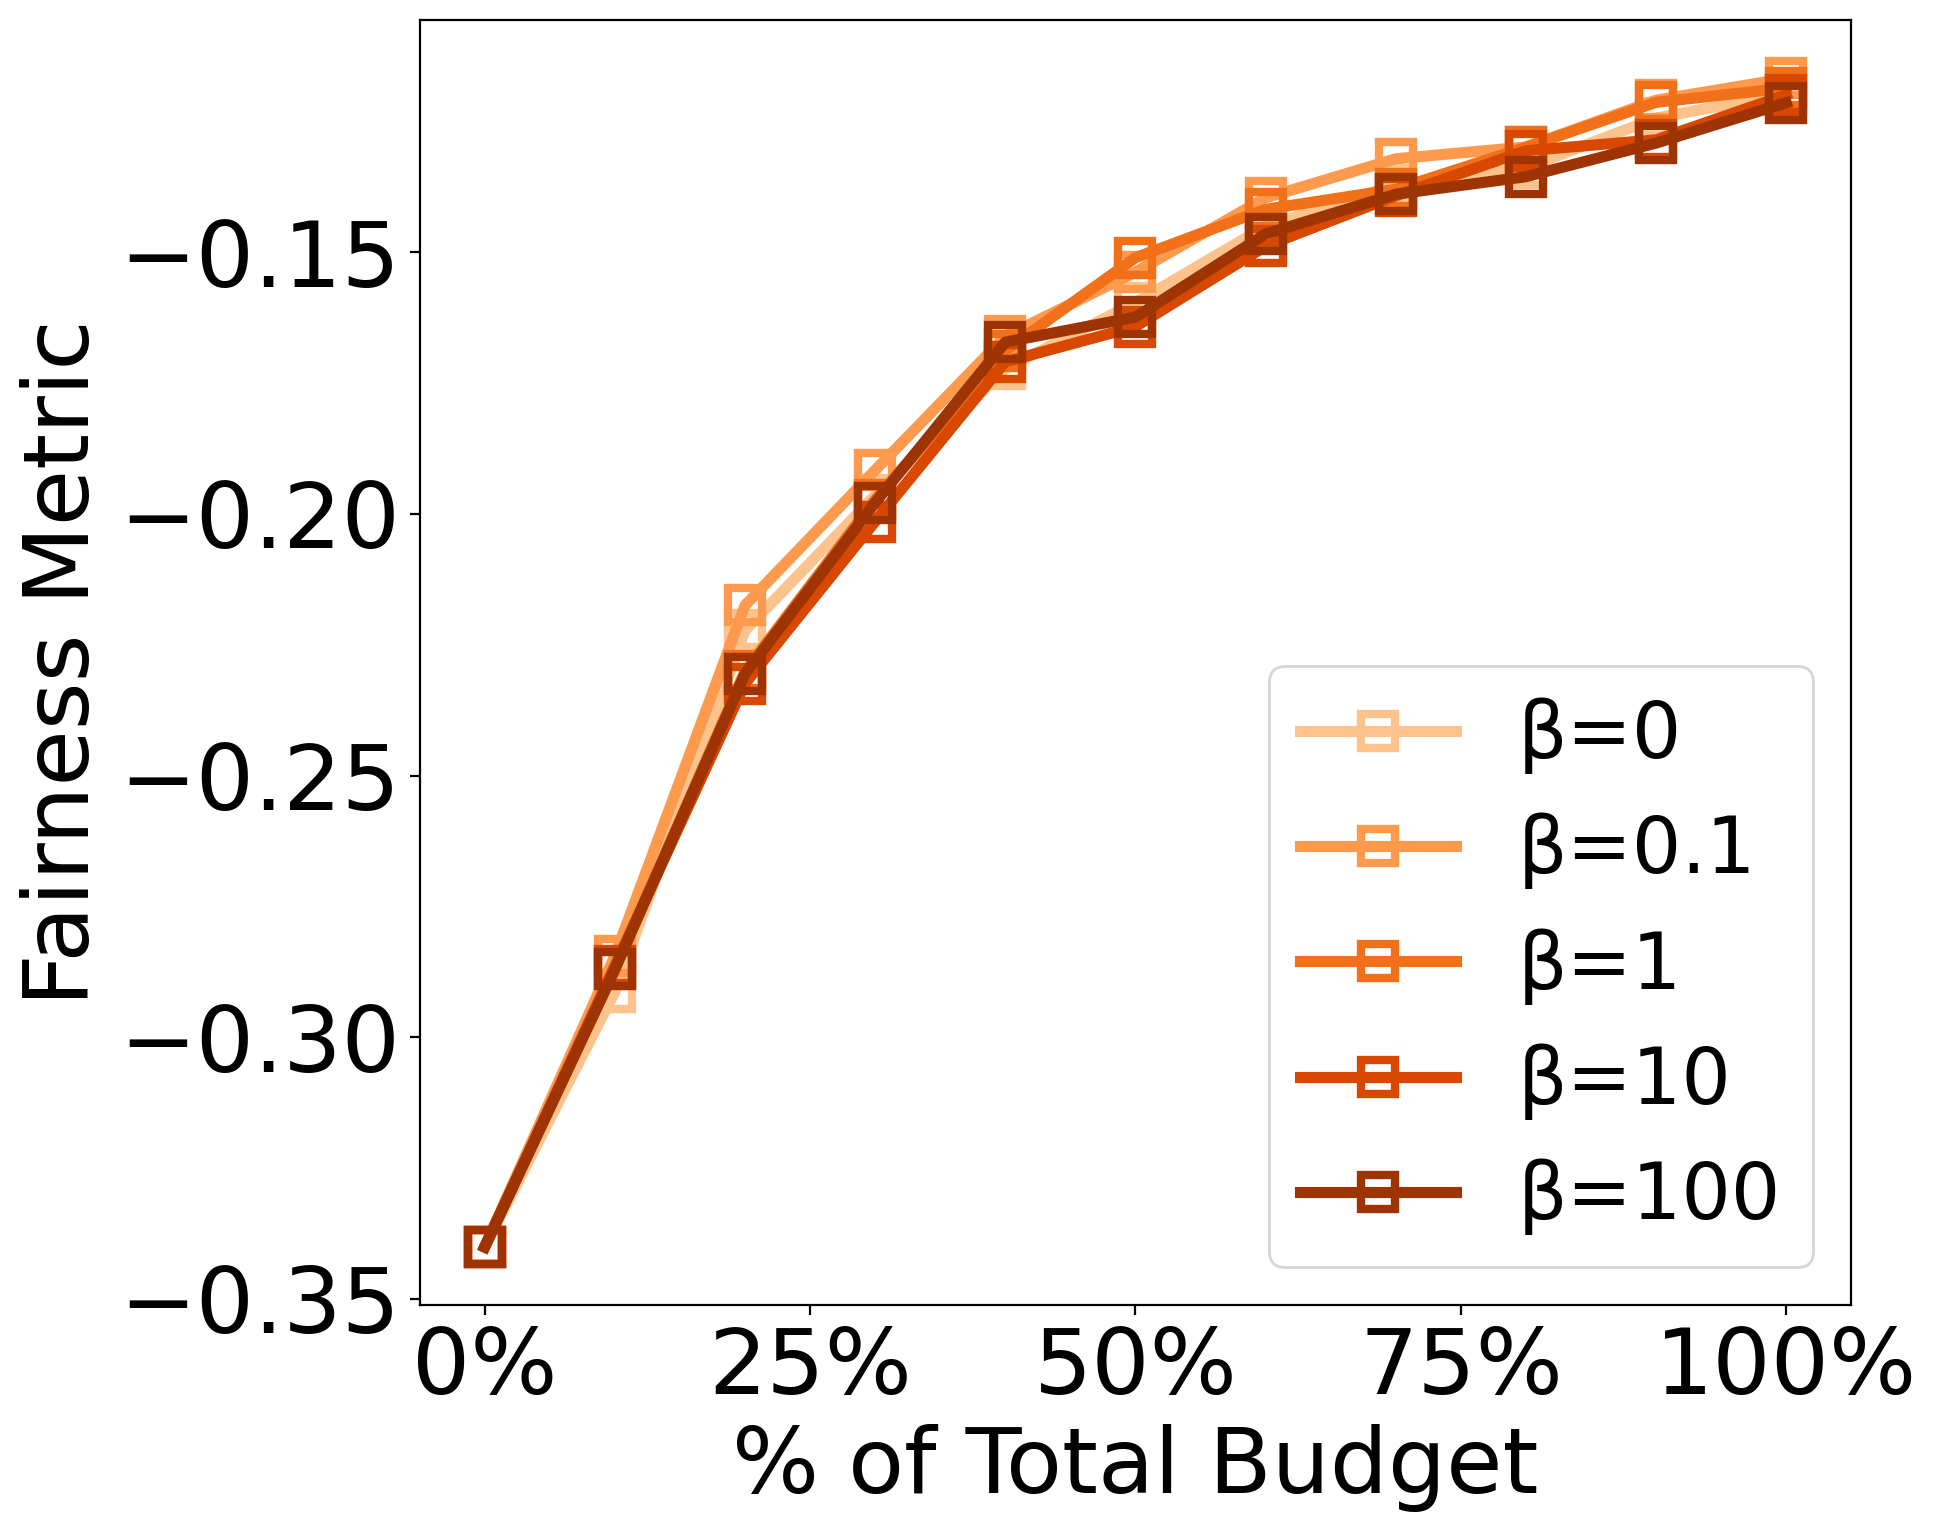

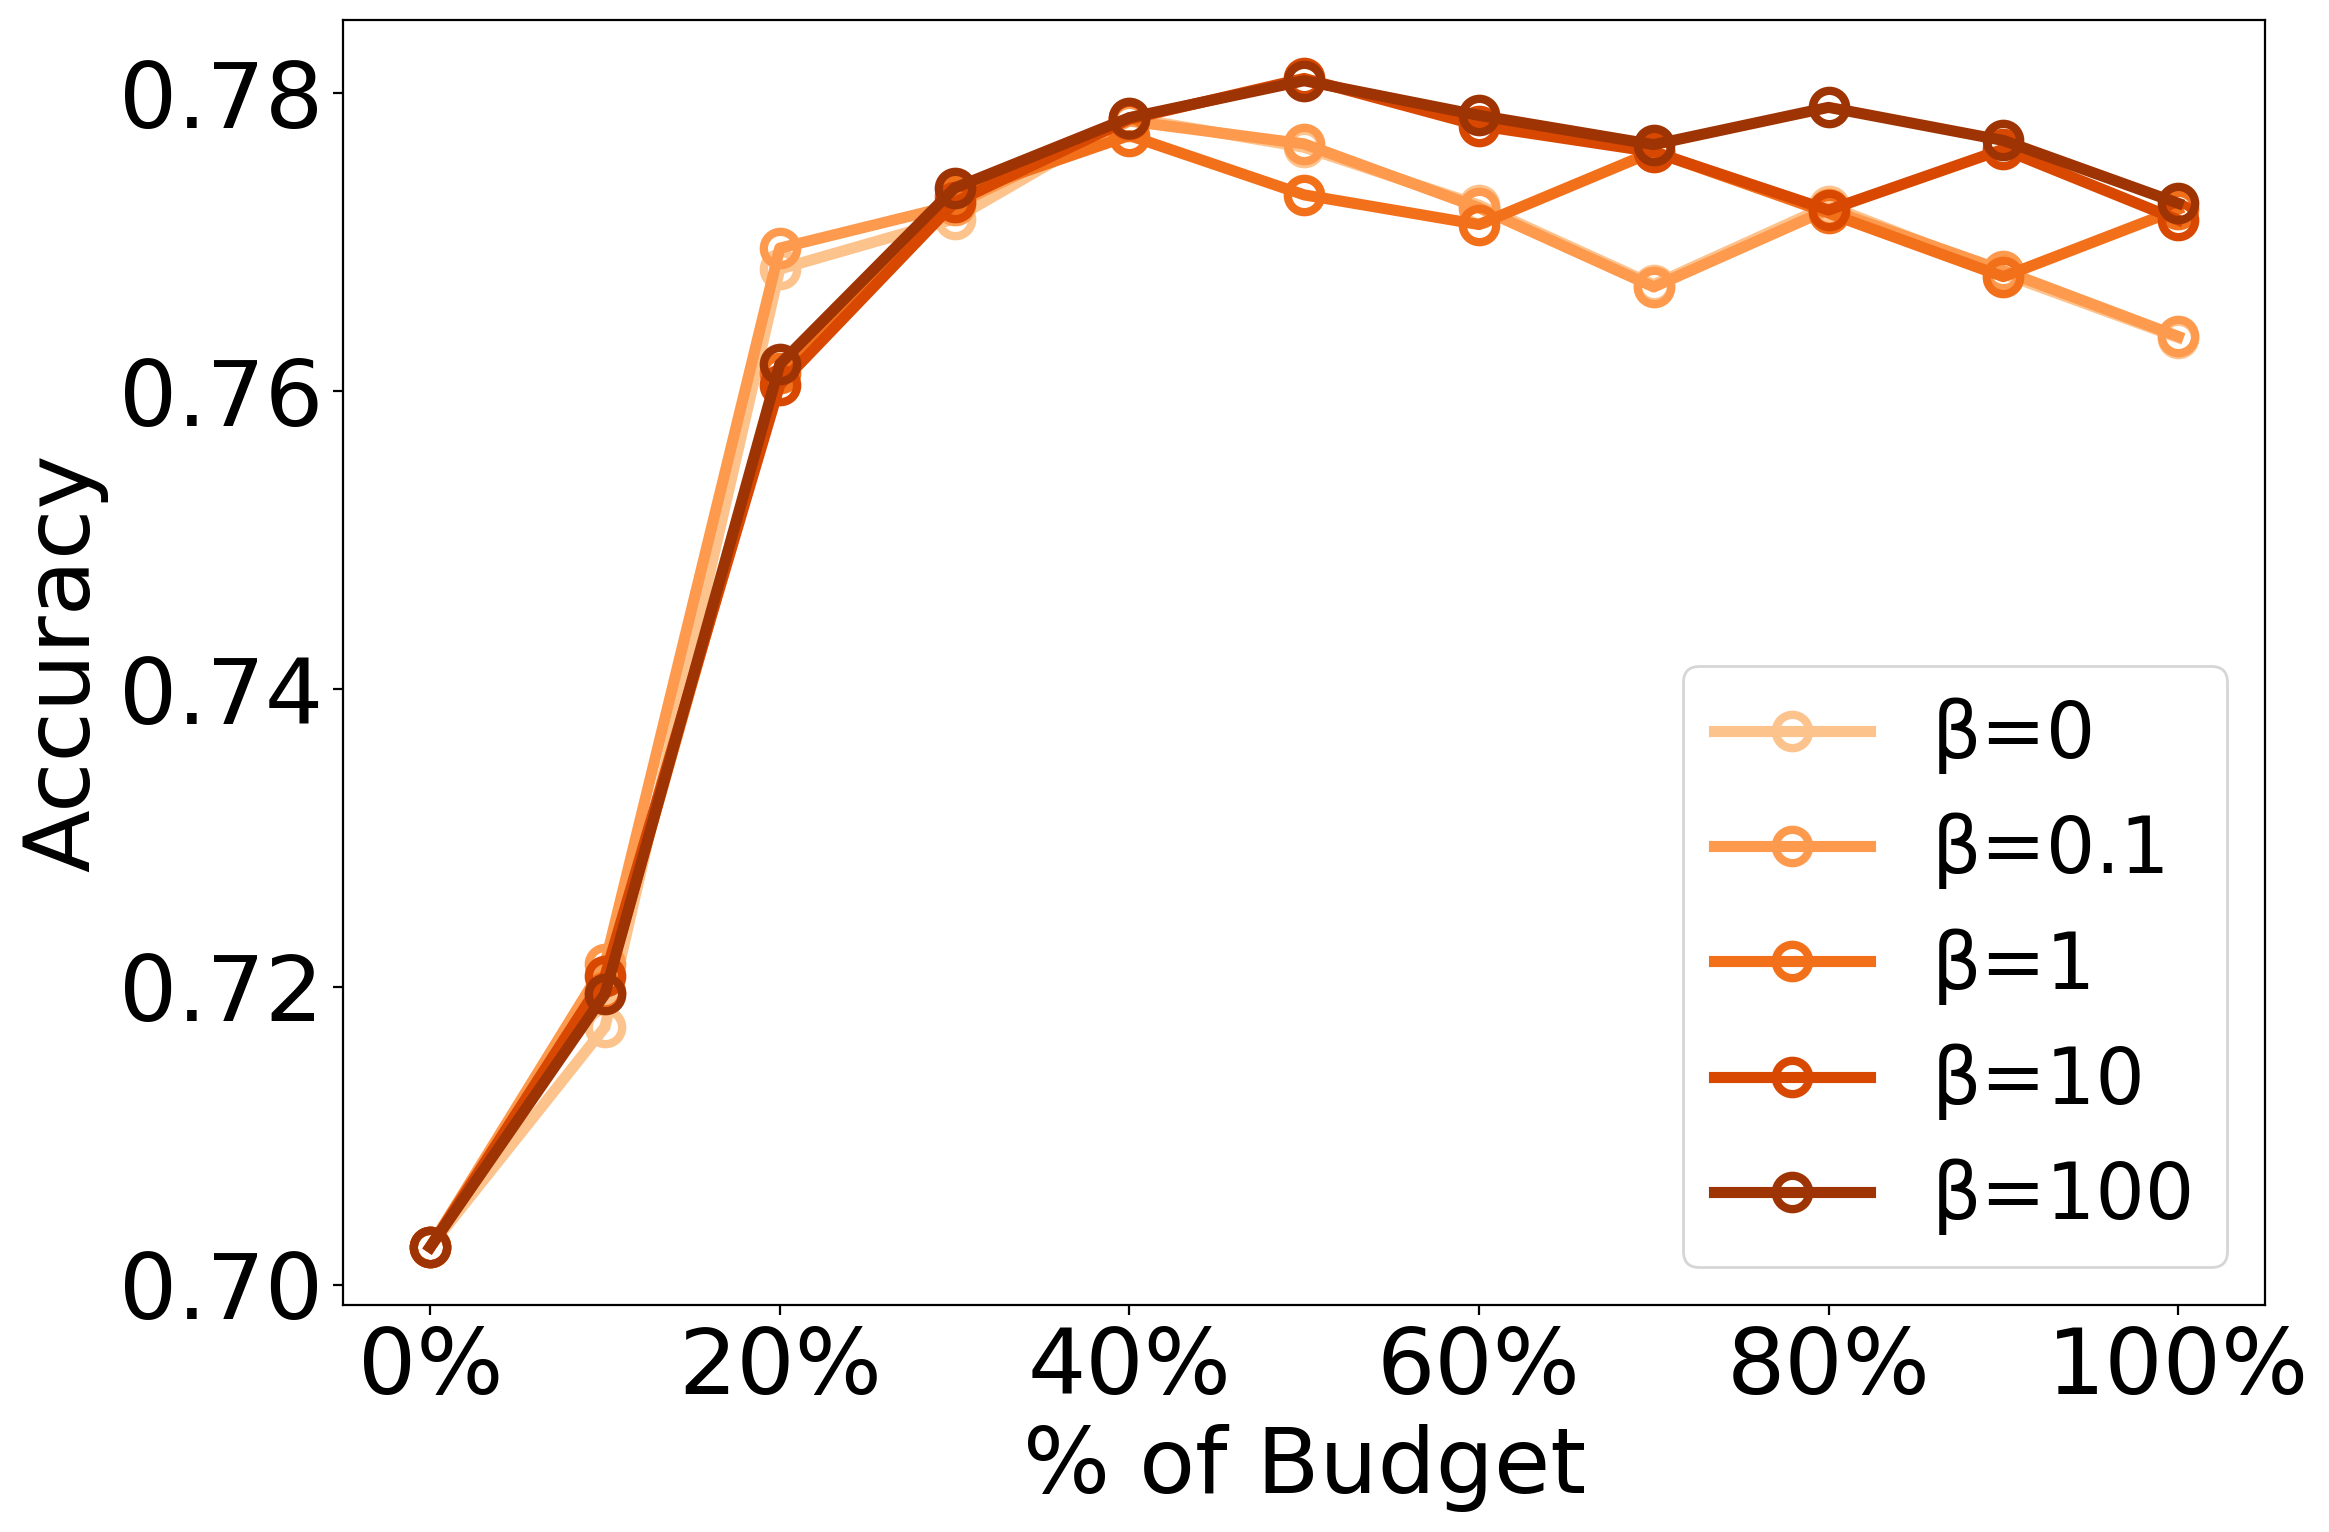

In [238]:
beta = [0, 0.1, 1, 10, 100]
folder_path = '/Users/hasan89/Documents/Plot_Revision/Ablation'
file_name = 'Beta_acc.pdf'
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

os.makedirs(folder_path, exist_ok=True)

cmap = plt.get_cmap('Oranges')
colors = cmap(np.linspace(0.3, 0.9, len(beta)))

stat_ex_list = []
acc_stat_list = []
i_values_ex_list = []
plt.figure(figsize=(10, 8))
for idx, (i, color) in enumerate(zip(beta, colors)):
    Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(
        clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute,
        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=0.01, beta=i)

    stat_ex_list.append(stat_ex)
    acc_stat_list.append(acc_stat)
    i_values_ex_list.append(i_values_ex_stat)

    plt.plot(i_values_ex_stat, stat_ex, markerfacecolor='none', marker='s', markeredgecolor=color,
         markeredgewidth=3, linestyle='-', linewidth=4, markersize=12, label=f'β={i}', color=color)

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=33)
plt.ylabel('Fairness Metric', fontsize=33)
plt.legend(fontsize=28, ncol=1)
plt.tick_params(axis='both', which='major', labelsize=33)
plt.tight_layout()
#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()

plt.figure(figsize=(12, 8))
for idx, (i, color) in enumerate(zip(beta, colors)):
    if idx < len(acc_stat_list):
        plt.plot(i_values_ex_list[idx], acc_stat_list[idx], marker='o', markerfacecolor='none', markeredgecolor=color,
         markeredgewidth=3, linestyle='-', linewidth=4, markersize=12, label=f'β={i}', color=color)

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Budget', fontsize=33)
plt.ylabel('Accuracy', fontsize=33)
plt.legend(fontsize=28, ncol=1)
plt.tick_params(axis='both', which='major', labelsize=33)
plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=600)
plt.show()

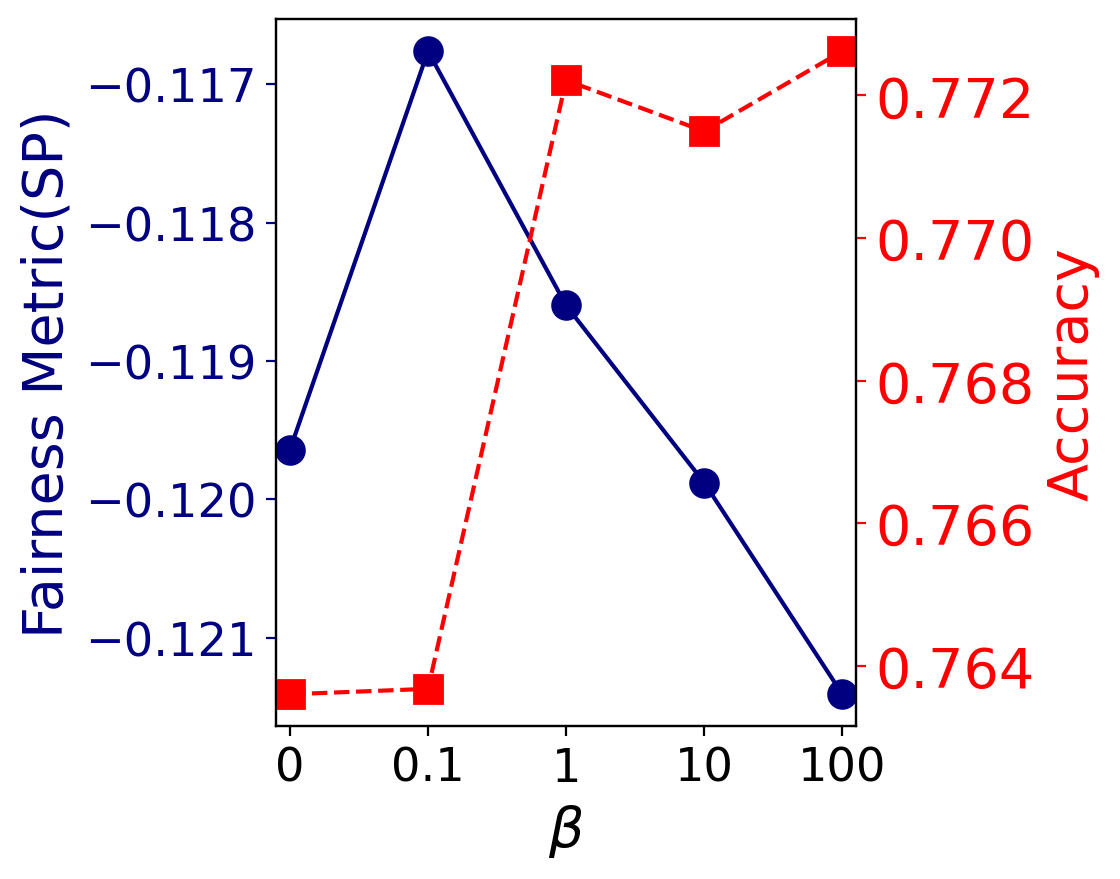

In [239]:
import matplotlib.pyplot as plt
import matplotlib

# Font and size settings from previous snippet
fsize = 20
params = {'legend.fontsize': fsize, 'legend.handlelength': 2}
plt.rcParams.update(params)

font = {'family': "sans serif", 'size': fsize}
matplotlib.rc('font', **font)

# Fallback data if not present
try:
    beta
    stat_ex_list
    acc_stat_list
except NameError:
    beta = [0, 0.1, 1, 10, 10]

# Extract last entries
last_stat_ex = [lst[-1] for lst in stat_ex_list]
last_acc_stat = [lst[-1] for lst in acc_stat_list]

# X positions
x_pos = list(range(len(beta)))
labels = [str(b) for b in beta]

plt.figure(figsize=(6, 4.8))
plt.xticks(fontsize=fsize/1.2)
plt.yticks(fontsize=fsize/1.2)

ax_left = plt.gca()

# Custom colors
color_left = 'navy'
color_right = 'red'

# Left axis
line_left, = ax_left.plot(x_pos, last_stat_ex, marker='o', linestyle='-', color=color_left, markersize=10, label='last_stat_ex')
ax_left.set_ylabel('Fairness Metric(SP)', color=color_left)
ax_left.tick_params(axis='y', colors=color_left)

# Right axis
ax_right = ax_left.twinx()
line_right, = ax_right.plot(x_pos, last_acc_stat, marker='s', linestyle='--', color=color_right,markersize=10, label='last_acc_stat')
ax_right.set_ylabel('Accuracy', color=color_right)
ax_right.tick_params(axis='y', colors=color_right)

# X-axis settings
ax_left.set_xticks(x_pos)
ax_left.set_xticklabels(labels)
ax_left.set_xlabel(r'$\beta$')


ax_left.set_xlim(-0.1, len(beta)-0.9)
ax_right.set_xlim(-0.1, len(beta)-0.9)

# Combined legend
lines = [line_left, line_right]
labels_lines = [l.get_label() for l in lines]
folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Ablation'
file_name = f"{dataset_name}_{model}_Beta.pdf"

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)
plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()


## Synthetic DataSet

In [240]:
print('DataSift', stat_ex[-1])
print('DataSift-Inf', MAB_inf_parity_ex[-1])
print('DataSift time', iteration_time1)
print('DataSift-Inf time', iteration_time_MAB_inf)

DataSift -0.12140927814732377
DataSift-Inf -0.006670278037428479
DataSift time 2.7164065837860107
DataSift-Inf time 0.5343790054321289


In [241]:
size = ['Original', 1e5, 2e5, 5e5, 1e6]
fairness_sys=[-0.0856, -0.1060, -0.1196, -0.1077, -0.1621]
fairness_sys_inf=[-0.0049, 0.00796, 0.0058, 0.01886, 0.015]
time_sys=[1.626, 1.313, 1.93, 2.43, 3.718]
time_sys_inf=[0.538, 0.482, 0.5343, 0.55, 0.5865]

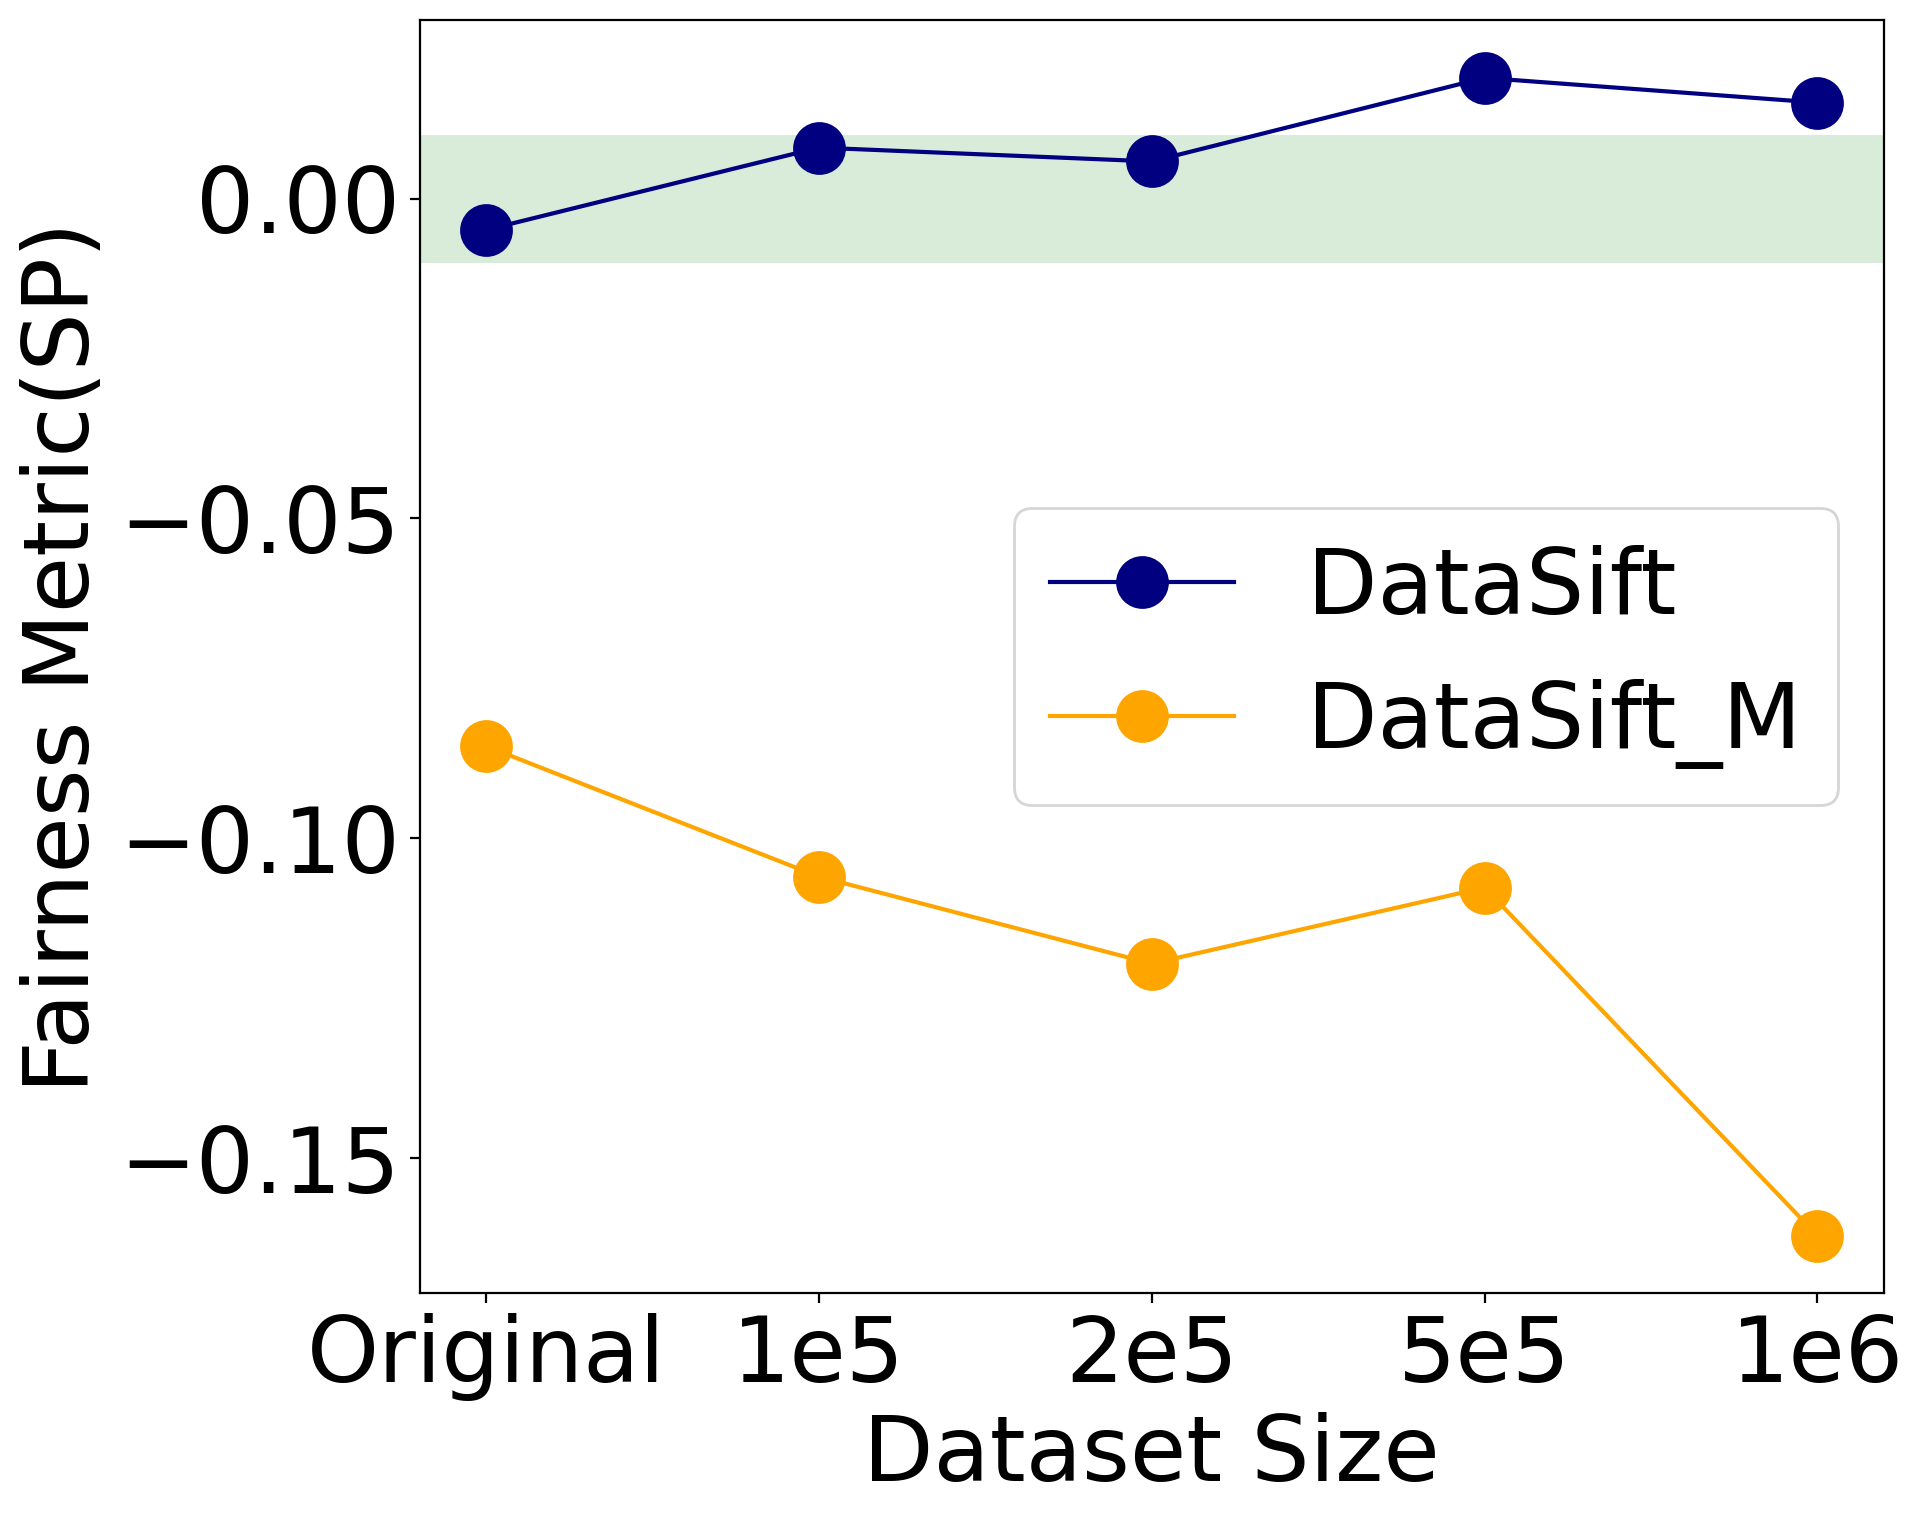

In [242]:
folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Ablation'
file_name = f"{dataset_name}_scaling_effective.pdf"
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

# create axes (replaces plt.figure(...))
fig, ax = plt.subplots(figsize=(10, 8))
size = ['Original', '1e5', '2e5', '5e5', '1e6']
ax.axhspan(-0.01, 0.01, facecolor='g', alpha=0.15, zorder=0)
plt.plot(size, fairness_sys_inf, marker='o', linestyle='-', color='navy', markersize=18,
         label='DataSift')

plt.plot(size, fairness_sys, marker='o', linestyle='-', color='orange', markersize=18,
         label='DataSift_M')
plt.xticks(range(len(size)), size)


plt.xlabel('Dataset Size', fontsize=33)
plt.ylabel('Fairness Metric(SP)', fontsize=33)
plt.legend(fontsize=33)
plt.tick_params(axis='both', which='major', labelsize=33)
plt.legend(fontsize=33, ncol=1)
plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
plt.show()

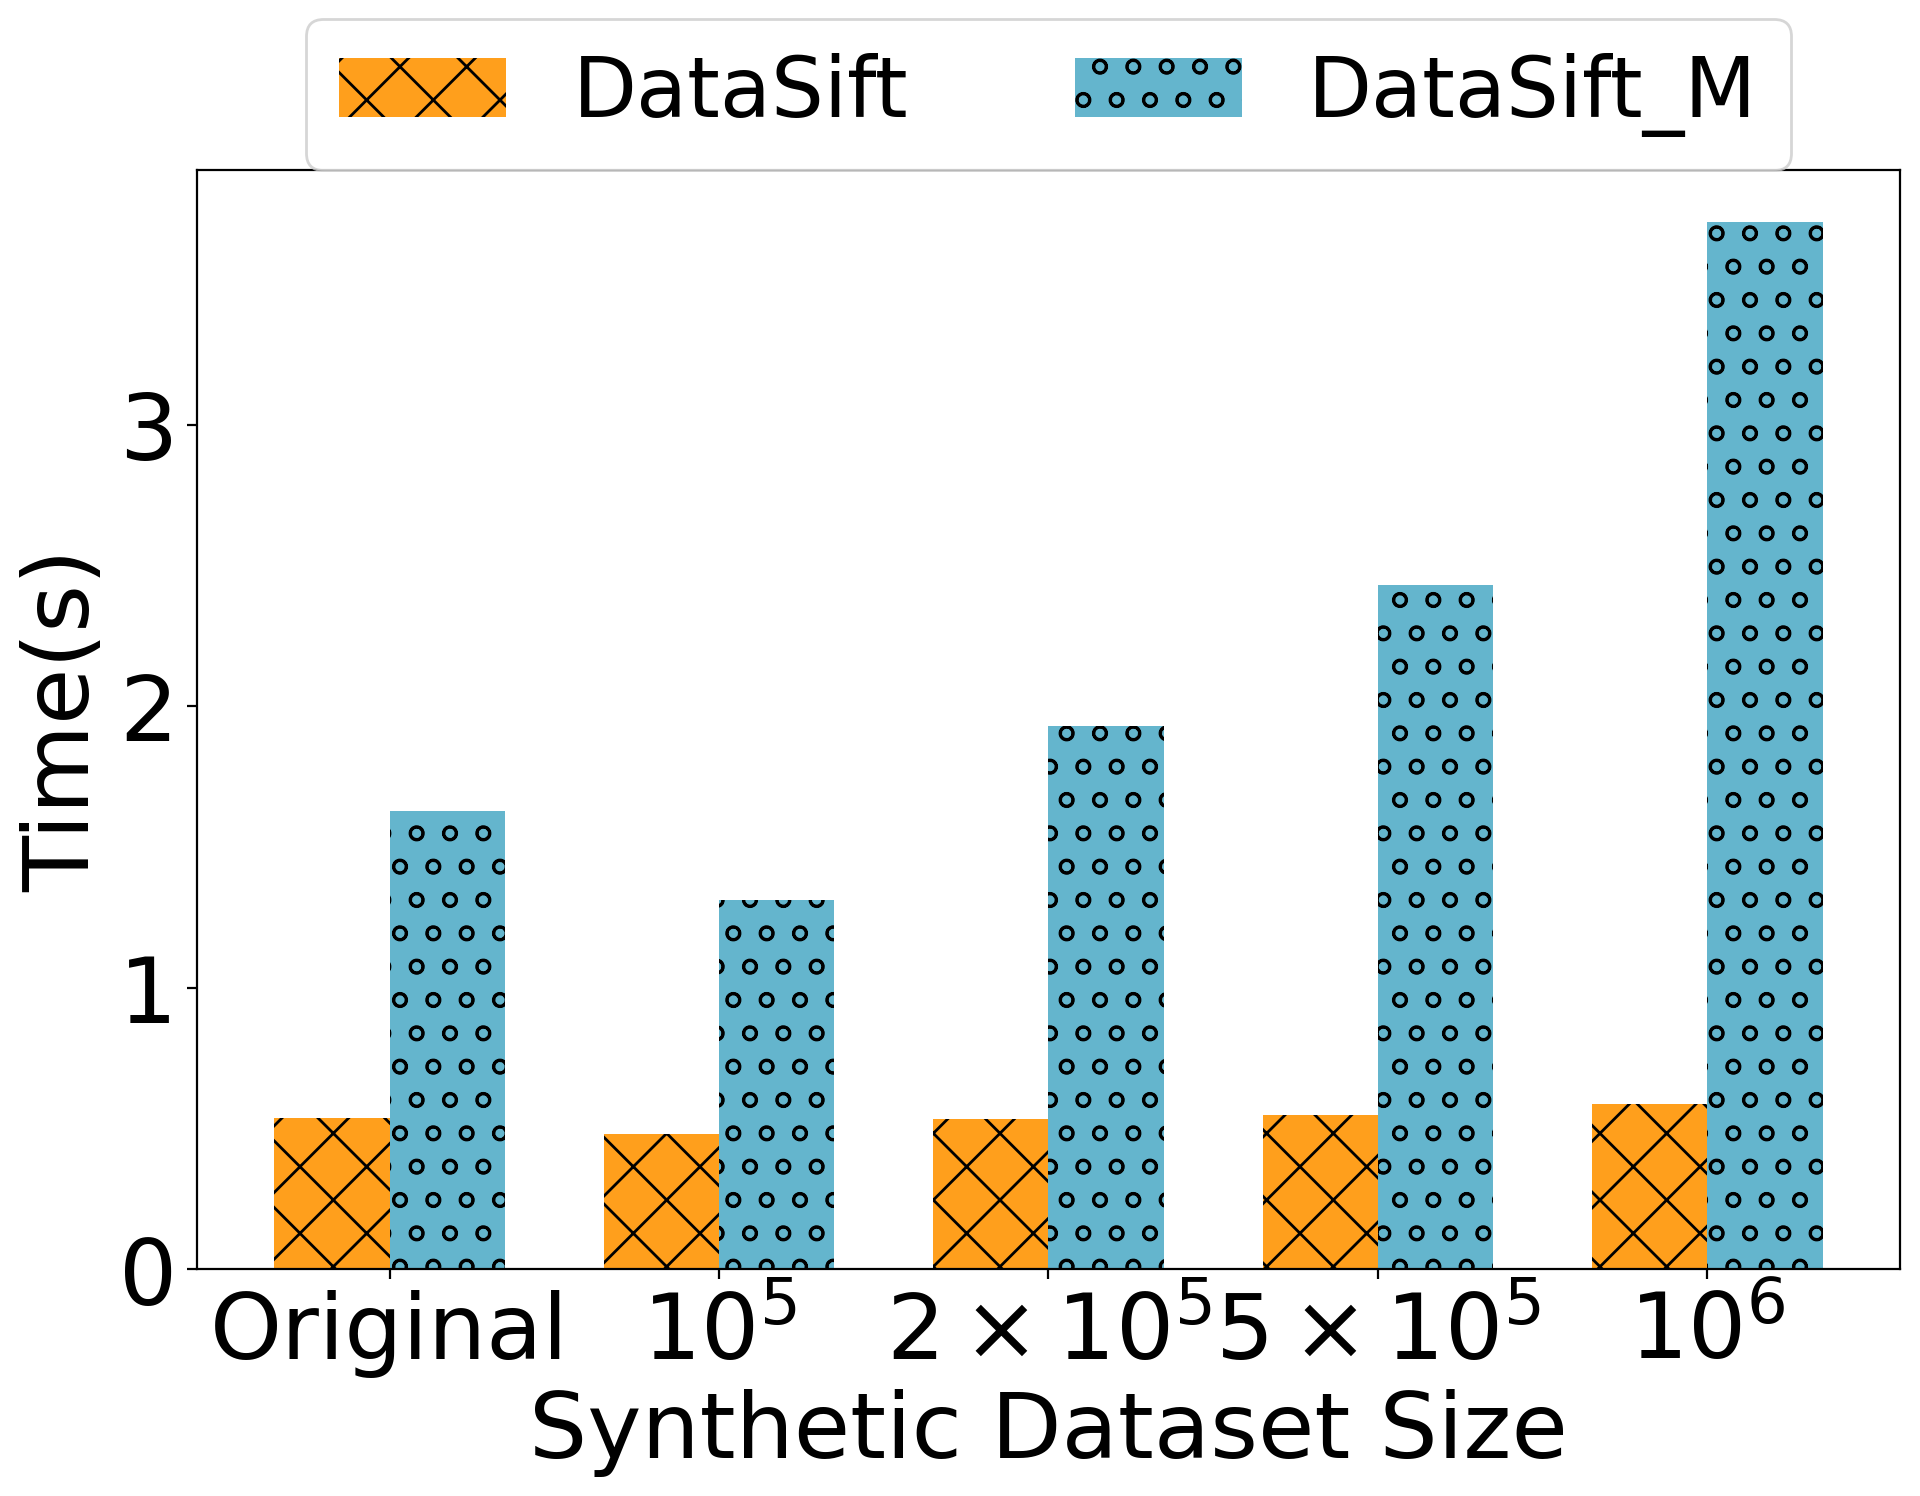

In [243]:
folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Ablation'
file_name = f"{dataset_name}_scaling_time.pdf"
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

# create axes (replaces plt.figure(...))
fig, ax = plt.subplots(figsize=(10, 8))
bar_width = 0.35
index = range(len(size))

plt.bar(index, time_sys_inf, width=bar_width, color='#FF9F1C', label='DataSift', hatch='x')
plt.bar([i + bar_width for i in index], time_sys, width=bar_width, color='#64B5CD', label='DataSift_M', hatch='o')


log_ticks = [1, 1e5, 2e5, 5e5, 1e6]
log_labels = ['Original', '$10^5$', '$2\\times 10^5$', '$5\\times 10^5$', '$10^6$']

plt.xticks([i + bar_width/2 for i in index], log_labels)
plt.xlabel('Synthetic Dataset Size', fontsize=33)
plt.ylabel('Time(s)', fontsize=33)
plt.legend(fontsize=30, loc='upper center', bbox_to_anchor=(0.5, 1.175), ncol=2)
plt.tick_params(axis='both', which='major', labelsize=33)

plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=600)
plt.show()

## Mini-Batch Size

In [244]:
mini_batch_pct = [2, 5, 10, 15, 20, 30, 50]
budget_pct = 20
data_acq_size = int(datapool.shape[0] * budget_pct // 100)

x_values = mini_batch_pct

mab_values = []
mab_inf_values = []
inf_values = []
random_values = []
entropy_values = []

for i in mini_batch_pct:
    mini_batch_size = int(data_acq_size * (i / 100))

    Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(
        clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, 
        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=0.1, beta=1)
    mab_values.append(stat_ex[-1])

    MAB_inf_update_data, MAB_inf_iteration_count, MAB_inf_iteration_count_ex, MAB_inf_parity_ex, stat_MAB_inf, MAB_inf_accuracy_ex, MAB_inf_time_per_iteration, MAB_inf_cluster_count, iteration_time_MAB_inf = mab_inf_algorithm(
        sort_by_inf_partition, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, 
        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=0.1, beta=1)
    mab_inf_values.append(MAB_inf_parity_ex[-1])

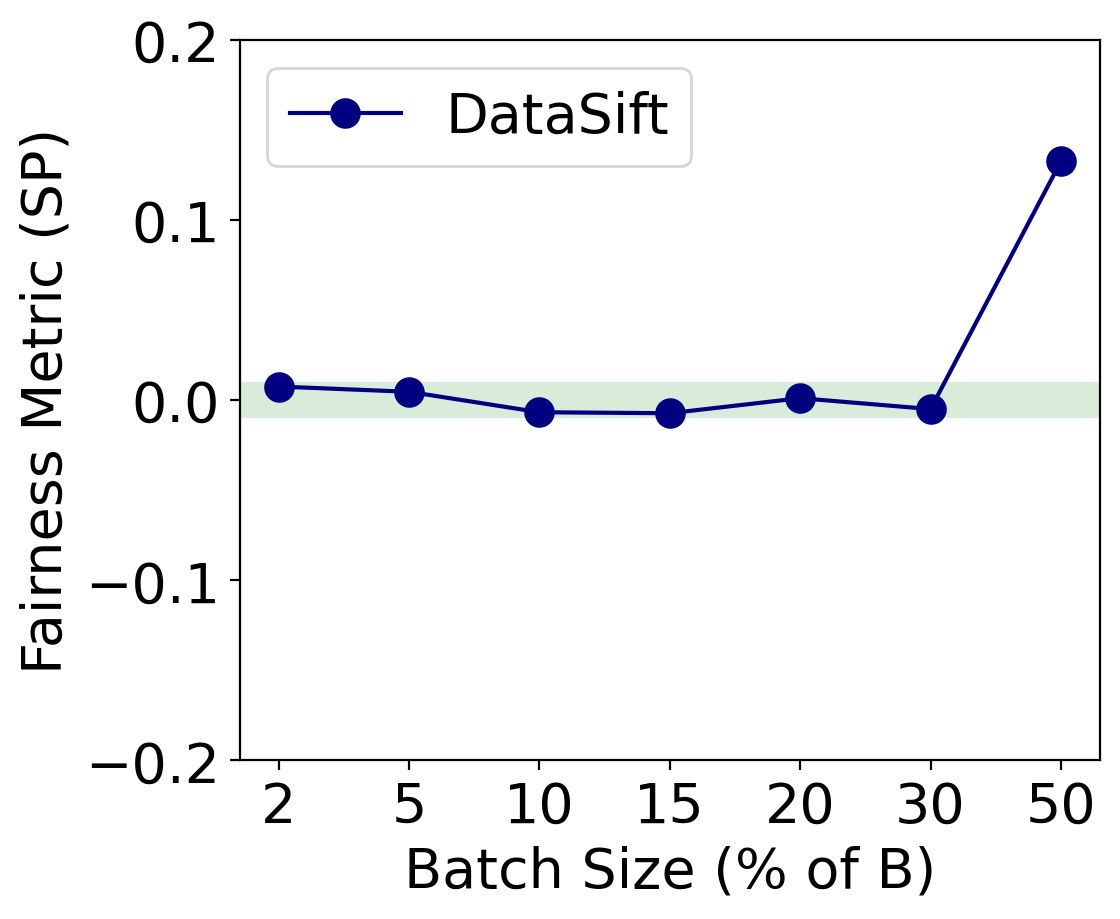

In [245]:

x_labels = [str(x) for x in x_values]
x_pos = list(range(len(x_values)))


folder_path = '/Users/hasan89/Documents/Datasift_EDBT/Plot/Ablation'
file_name = f"{dataset_name}_mini_batch.pdf"
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

fig, ax = plt.subplots(figsize=(6, 5))
plt.xticks(fontsize=fsize/1.4)
plt.yticks(fontsize=fsize/1.4)

ax.axhspan(-0.01, 0.01, facecolor='g', alpha=0.15, zorder=0)
ax.plot(x_pos, mab_inf_values, marker='o', linestyle='-', color='navy', markersize=10,
         label='DataSift')


ax.set_ylim(-0.2, 0.2)

ax.set_xlabel('Batch Size (% of B)', fontsize=20)
ax.set_ylabel('Fairness Metric (SP)')
plt.xticks(ticks=x_pos, labels=x_labels, fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20, ncol=1)
plt.tight_layout()
#plt.savefig(file_path, format='pdf', dpi=1600, bbox_inches='tight', pad_inches=0.1)
plt.show()
